In [1]:
import os
import lmdb
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from hep_ml import splot
from scipy.optimize import curve_fit
from scipy.special import voigt_profile
from sklearn.metrics import auc
from sklearn.model_selection import StratifiedKFold

In [2]:
label_fontsize = 20
title_fontsize = 22
legend_fontsize = 12
tick_fontsize = 14

In [3]:
figure_dir = 'src/figures'

In [4]:
def hist_ab(var_a, var_b, a_weight=None, b_weight=None, bins=32, alabel=None, blabel=None, xlabel=None,
    ylabel=None, title=None, density=True, range=None, shaded=None, savename=None):
    fig, ax = plt.subplots()
    hist_a,bins,_= ax.hist(var_a, bins=32, alpha=0.35, weights=a_weight,
        label=alabel, density=density, range=range, color='blue');
    ax.hist(var_a, bins=bins,histtype='step', weights=a_weight,
        density=density, range=range, color='blue', alpha=0.75, linewidth=2);
    hist_b, _, _ = ax.hist(var_b, bins=bins, alpha=0.35, weights=b_weight,
        label=blabel, density=density, range=range, color='orange');
    ax.hist(var_b, bins=bins, histtype='step', weights=b_weight,
        density=density, range=range, color='orange', alpha=0.75, linewidth=2);
    ax.tick_params(labelsize=tick_fontsize)
    ax.set_xlabel(xlabel,fontsize=label_fontsize)
    ax.set_ylabel(ylabel,fontsize=label_fontsize)
    ax.set_title(title,fontsize=title_fontsize)
    ax.legend(fontsize=legend_fontsize)
    if shaded is not None:
        min_mass = np.concatenate([var_a,var_b]).min()
        max_mass = np.concatenate([var_a,var_b]).max()
        max_count = np.concatenate([hist_a,hist_b]).max()
        x_lo = np.linspace(min_mass,shaded[0])
        x_hi = np.linspace(shaded[1],max_mass)
        ax.fill_between(x_lo,0,max_count,where=(x_lo<shaded[0]),color='grey',alpha=0.3)
        ax.fill_between(x_hi,0,max_count,where=(x_hi>shaded[1]),color='grey',alpha=0.3)
    if savename is not None:
        plt.savefig(savename, bbox_inches='tight')

In [5]:
def hist_abcd(var_a, var_b, var_c, var_d, a_weight=None, b_weight=None, c_weight=None, d_weight=None,
              bins=32, alabel=None, blabel=None, clabel=None, dlabel=None, xlabel=None, ylabel=None, 
              title=None, density=True, range=None, shaded=None, savename=None):
    fig, ax = plt.subplots()
    hist_a,bins,_= ax.hist(var_a, bins=32, alpha=0.35, weights=a_weight,
        label=alabel, density=True, range=range, color='blue');
    ax.hist(var_a, bins=bins,histtype='step', weights=a_weight,
        density=density, range=range, color='blue', alpha=0.75, linewidth=2);
    hist_b, _, _ = ax.hist(var_b, bins=bins, alpha=0.35, weights=b_weight,
        label=blabel, density=True, range=range, color='orange');
    ax.hist(var_b, bins=bins, histtype='step', weights=b_weight,
        density=True, range=range, color='orange', alpha=0.75, linewidth=2);
    hist_c,bins,_= ax.hist(var_c, bins=32, alpha=0.35, weights=c_weight,
        label=clabel, density=True, range=range, color='blue', histtype='step',linestyle='dashed',linewidth=3);
    hist_d, _, _ = ax.hist(var_d, bins=bins, alpha=0.35, weights=d_weight,
        label=dlabel, density=True, range=range, color='orange', histtype='step',linestyle='dashed',linewidth=3);
    ax.tick_params(labelsize=tick_fontsize)
    ax.set_xlabel(xlabel,fontsize=label_fontsize)
    ax.set_ylabel(ylabel,fontsize=label_fontsize)
    ax.set_title(title,fontsize=title_fontsize)
    ax.legend(fontsize=legend_fontsize)
    if shaded is not None:
        min_mass = np.concatenate([var_a,var_b,var_c,var_d]).min()
        max_mass = np.concatenate([var_a,var_b,var_c,var_d]).max()
        max_count = np.concatenate([hist_a,hist_b,hist_c,hist_d]).max()
        x_lo = np.linspace(min_mass,shaded[0])
        x_hi = np.linspace(shaded[1],max_mass)
        ax.fill_between(x_lo,0,max_count,where=(x_lo<shaded[0]),color='grey',alpha=0.3)
        ax.fill_between(x_hi,0,max_count,where=(x_hi>shaded[1]),color='grey',alpha=0.3)
    if savename is not None:
        plt.savefig(savename, bbox_inches='tight')

In [6]:
seed = 123
M_lo = 70
M_hi = 110
pos_lo = 84
pos_hi = 96
pT_bound = 25
eta_bound = 2.1
kfold_index = 0
num_folds = 5
data_dir = 'src/data'
rng = np.random.default_rng(seed)

m = pd.read_csv(f'{data_dir}/cms_csvs/dimuon_invariant_mass.csv', header=None).to_numpy().squeeze()
pT = pd.read_csv(f'{data_dir}/cms_csvs/muon_pTs.csv', header=None).to_numpy()
eta = pd.read_csv(f'{data_dir}/cms_csvs/muon_etas.csv', header=None).to_numpy()
phi = pd.read_csv(f'{data_dir}/cms_csvs/muon_phis.csv', header=None).to_numpy()
q = pd.read_csv(f'{data_dir}/cms_csvs/muon_charges.csv', header=None).to_numpy()

M_selection = ((m > M_lo) & (m < M_hi))
eta_selection = (np.abs(eta)[:,0] < eta_bound) & (np.abs(eta)[:,1] < eta_bound) 
pT_selection = (pT[:,0] > pT_bound) & (pT[:,1] > pT_bound) 
selection = M_selection & eta_selection & pT_selection
selection = np.argwhere(selection).flatten()

label = np.ones(len(m))
label[m < pos_lo] = 0
label[m > pos_hi] = 0
label[np.prod(q,axis=1)>0] = 0

shuffle = np.arange(len(selection))
rng.shuffle(shuffle)
selection = selection[shuffle]

kf = StratifiedKFold(n_splits=num_folds+1, shuffle=False)
split = list(kf.split(selection, y=label[selection]))
test_split = split[0][1]
train_split, valid_split = split[kfold_index+1]
train_split = np.delete(train_split, np.argwhere(np.isin(train_split,test_split)).flatten())
valid_split = np.delete(valid_split, np.argwhere(np.isin(valid_split,test_split)).flatten())
train_index = selection[train_split] 
valid_index = selection[valid_split]
test_index = selection[test_split]

train_index = np.sort(train_index)
valid_index = np.sort(valid_index)
test_index = np.sort(test_index)
sig_i = np.concatenate([train_index[label[train_index]==1],
    valid_index[label[valid_index]==1],test_index[label[test_index]==1]])
bg_i = np.concatenate([train_index[label[train_index]==0],
    valid_index[label[valid_index]==0],test_index[label[test_index]==0]])
os_i = np.concatenate([train_index[np.prod(q[train_index],axis=1)<0],
    valid_index[np.prod(q[valid_index],axis=1)<0],test_index[np.prod(q[test_index],axis=1)<0]])
ss_i = np.concatenate([train_index[np.prod(q[train_index],axis=1)>0],
    valid_index[np.prod(q[valid_index],axis=1)>0],test_index[np.prod(q[test_index],axis=1)>0]])

In [19]:
print(len(os_i),len(ss_i),len(os_i)+len(ss_i))

1074069 4657 1078726


In [157]:
sim_csv_dir = 'src/data/sim_csvs'
sim_label = pd.read_csv(f'{sim_csv_dir}/muon_labels.csv', header=None).to_numpy().squeeze()
sim_m = pd.read_csv(f'{sim_csv_dir}/masses.csv', header=None).to_numpy().squeeze()
sim_muon_pT = pd.read_csv(f'{sim_csv_dir}/muon_pTs.csv', header=None).to_numpy()
sim_muon_eta = pd.read_csv(f'{sim_csv_dir}/muon_etas.csv', header=None).to_numpy()
sim_muon_phis = pd.read_csv(f'{sim_csv_dir}/muon_phis.csv', header=None).to_numpy()

In [158]:
sim_pfn_dir = 'src/data/pfn_sim'
sim_env = lmdb.open(f'{sim_pfn_dir}', readonly=True)
sim_txn = sim_env.begin()

In [159]:
sim_event_pT = np.empty((sim_env.stat()['entries'],512))
sim_event_eta = np.empty((sim_env.stat()['entries'],512))
sim_event_phi = np.empty((sim_env.stat()['entries'],512))
for i in range(sim_env.stat()['entries']):
    pfn_rep = np.frombuffer(sim_txn.get(str(i).encode())).reshape((512,3))
    sim_event_pT[i] = pfn_rep[:,0]
    sim_event_eta[i] = pfn_rep[:,1]
    sim_event_phi[i] = pfn_rep[:,2]

In [160]:
np.unique(sim_label,return_counts=True)

(array([0., 1.]), array([11383, 11383]))

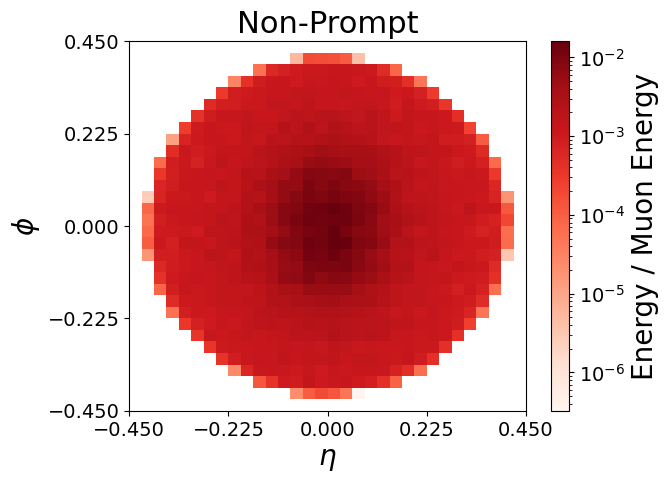

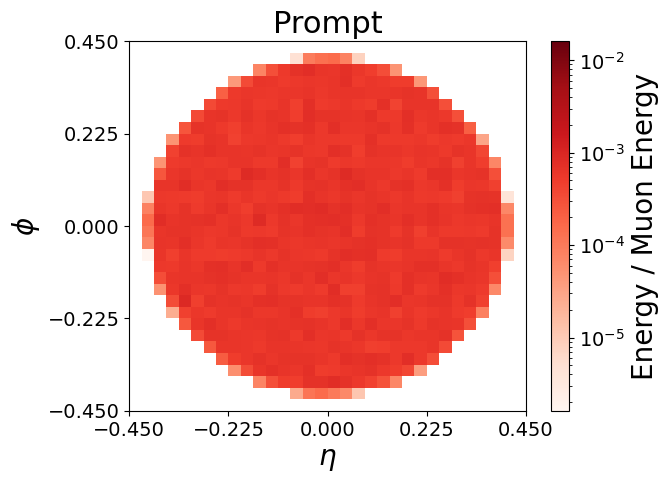

In [163]:
fig,ax = plt.subplots()
bg_h,_,_,im = ax.hist2d(sim_event_eta[sim_label==0].flatten(),
    sim_event_phi[sim_label==0].flatten(),
    weights=(sim_event_pT[sim_label==0]/sim_muon_pT[sim_label==0]).flatten()
            / len(sim_label[sim_label==0]),
    range=[[-0.45,0.45],[-0.45,0.45]],bins=32,cmap='Reds',
    density=False,norm=mpl.colors.LogNorm())
ax.set_title('Non-Prompt',fontsize=title_fontsize)
ax.set_xticks([-0.45,-0.225,0,0.225,0.45])
ax.set_yticks([-0.45,-0.225,0,0.225,0.45])
ax.set_xlabel(r'$\eta$',fontsize=label_fontsize)
ax.set_ylabel(r'$\phi$',fontsize=label_fontsize)
ax.tick_params(labelsize=tick_fontsize)
cb = fig.colorbar(im)
cb.set_label(label='Energy / Muon Energy',fontsize=label_fontsize)
cb.ax.tick_params(labelsize=tick_fontsize)
fig.savefig(f'{figure_dir}/sim_nonprompt_avg.pdf',bbox_inches='tight')
plt.show()
vmax = bg_h.max()
fig,ax = plt.subplots()
sig_h,_,_,im = ax.hist2d(sim_event_eta[sim_label==1].flatten(),
    sim_event_phi[sim_label==1].flatten(),
    weights=(sim_event_pT[sim_label==1]/sim_muon_pT[sim_label==1]).flatten()
            / len(sim_label[sim_label==1]),
    range=[[-0.45,0.45],[-0.45,0.45]],bins=32,cmap='Reds',
    density=False,norm=mpl.colors.LogNorm(vmax=vmax))
ax.set_title('Non-Prompt',fontsize=title_fontsize)
ax.set_title('Prompt',fontsize=title_fontsize)
ax.set_xticks([-0.45,-0.225,0,0.225,0.45])
ax.set_yticks([-0.45,-0.225,0,0.225,0.45])
ax.set_xlabel(r'$\eta$',fontsize=label_fontsize)
ax.set_ylabel(r'$\phi$',fontsize=label_fontsize)
ax.tick_params(labelsize=tick_fontsize)
cb = fig.colorbar(im)
cb.set_label(label='Energy / Muon Energy',fontsize=label_fontsize)
cb.ax.tick_params(labelsize=tick_fontsize)
fig.savefig(f'{figure_dir}/sim_prompt_avg.pdf',bbox_inches='tight')
plt.show()

In [31]:
sim_selection = np.sqrt(sim_event_eta.flatten()**2 + sim_event_phi.flatten()**2)<=0.45
init_shape = sim_event_pT.shape
sim_event_pT = sim_event_pT.flatten()
sim_event_pT[np.invert(sim_selection)] = 0.
sim_event_pT = sim_event_pT.reshape(init_shape)
sum_pT = np.sum(sim_event_pT,axis=1)

In [33]:
sim_pfn_dir = 'src/cross_validation/sim_pfn/lightning_logs/trainsize_1.0_fold_0'
num_gpus = 4
test_idx = []
test_true_labels = []
test_cwola_labels = []
test_outs = []
test_masses= []
for i in range(num_gpus):
    test_idx.append(np.load(f'{sim_pfn_dir}/test_idx_cuda:{i}.npy'))
    test_true_labels.append(np.load(f'{sim_pfn_dir}/test_truelabels_cuda:{i}.npy'))
    test_cwola_labels.append(np.load(f'{sim_pfn_dir}/test_labels_cuda:{i}.npy'))
    test_outs.append(np.load(f'{sim_pfn_dir}/test_outs_cuda:{i}.npy'))
    test_masses.append(np.load(f'{sim_pfn_dir}/test_masses_cuda:{i}.npy'))
test_idx = np.concatenate(test_idx).flatten()
test_idx, unique_filter = np.unique(test_idx,return_index=True)
test_cwola_labels = np.concatenate(test_cwola_labels).flatten()[unique_filter]
test_true_labels = np.concatenate(test_true_labels).flatten()[unique_filter]
test_outs = np.concatenate(test_outs).flatten()[unique_filter]
test_masses = np.concatenate(test_masses).flatten()[unique_filter]

In [34]:
sim_sig_i = np.int32(test_idx[test_true_labels==1])
sim_bg_i = np.int32(test_idx[test_true_labels==0])
mix_bools = (test_masses > pos_lo) & (test_masses < pos_hi)
sim_mix_sig_i = np.int32(test_idx[mix_bools])
sim_mix_bg_i = np.int32(test_idx[np.invert(mix_bools)])

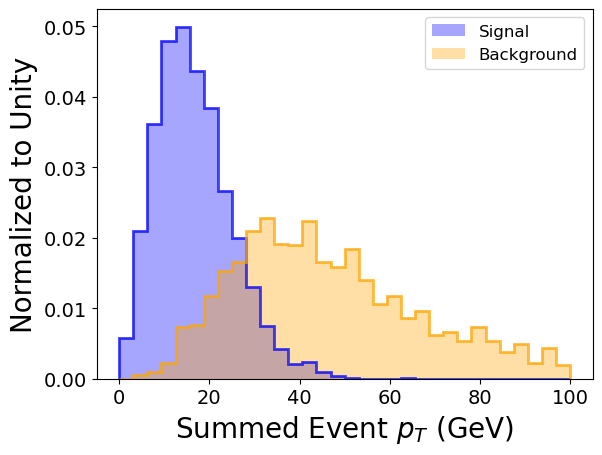

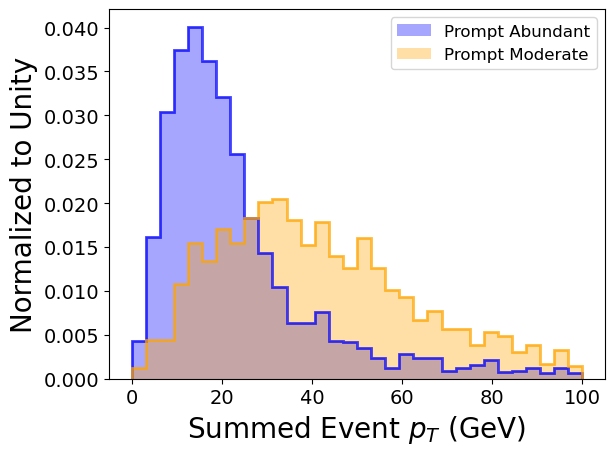

In [102]:
hist_ab(sum_pT[sim_sig_i], sum_pT[sim_bg_i], bins=32, range=[0,100], 
    alabel='Signal', blabel='Background', xlabel='Summed Event $p_T$ (GeV)', 
    ylabel='Normalized to Unity',savename=f'{figure_dir}/sim_pT_sig_bg_total.pdf')
plt.show()
hist_ab(sum_pT[sim_mix_sig_i], sum_pT[sim_mix_bg_i], bins=32, range=[0,100],
    alabel='Prompt Abundant', blabel='Prompt Moderate', xlabel='Summed Event $p_T$ (GeV)', 
    ylabel='Normalized to Unity',savename=f'{figure_dir}/sim_pT_mix1_mix2_total.pdf')
plt.show()

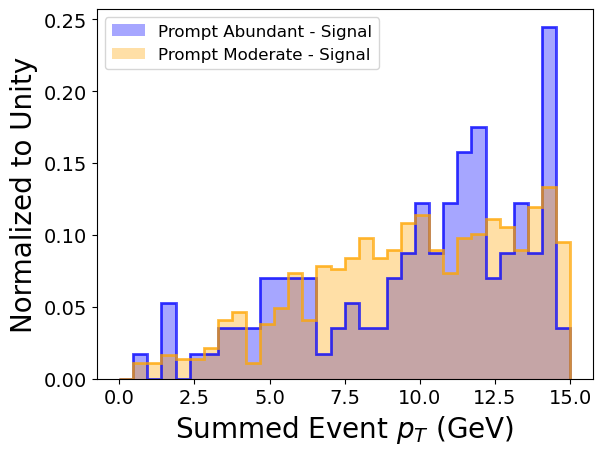

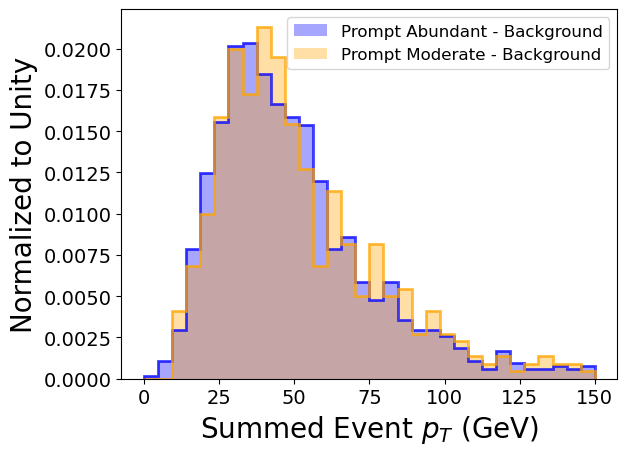

In [89]:
hist_ab(sum_pT[sim_mix_bg_i[sim_label[sim_mix_bg_i]==1]], 
    sum_pT[sim_mix_sig_i[sim_label[sim_mix_sig_i]==1]], 
    bins=32, range=[0,15], alabel='Prompt Abundant - Signal', blabel='Prompt Moderate - Signal', 
    xlabel='Summed Event $p_T$ (GeV)', ylabel='Normalized to Unity', savename=f'{figure_dir}/sim_pT_sig_only.pdf')
plt.show()
hist_ab(sum_pT[sim_mix_bg_i[sim_label[sim_mix_bg_i]==0]], 
    sum_pT[sim_mix_sig_i[sim_label[sim_mix_sig_i]==0]], 
    bins=32, range=[0,150], alabel='Prompt Abundant - Background', blabel='Prompt Moderate - Background', 
    xlabel='Summed Event $p_T$ (GeV)', ylabel='Normalized to Unity', savename=f'{figure_dir}/sim_pT_bg_only.pdf')
plt.show()

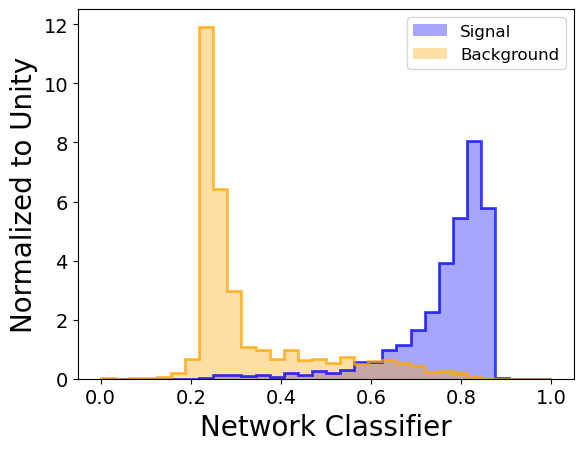

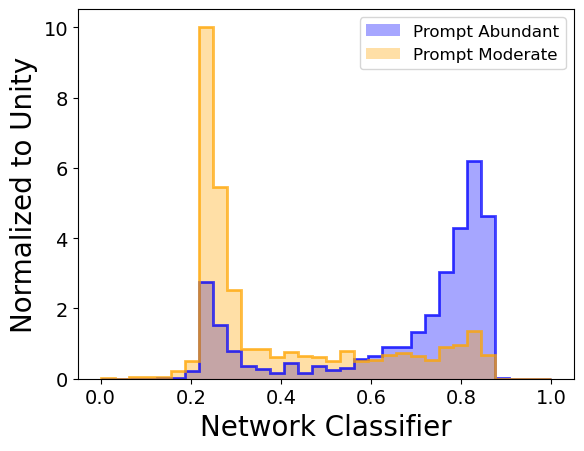

In [90]:
hist_ab(test_outs[test_true_labels==1], test_outs[test_true_labels==0],
    bins=32, range=[0,1], 
    alabel='Signal', blabel='Background', xlabel='Network Classifier', 
    ylabel='Normalized to Unity', savename=f'{figure_dir}/sim_nn_sig_bg_total.pdf')
plt.show()
hist_ab(test_outs[mix_bools], test_outs[np.invert(mix_bools)],
    bins=32, range=[0,1],
    alabel='Prompt Abundant', blabel='Prompt Moderate', xlabel='Network Classifier', 
    ylabel='Normalized to Unity', savename=f'{figure_dir}/sim_nn_mix1_mix2_total.pdf')
plt.show()

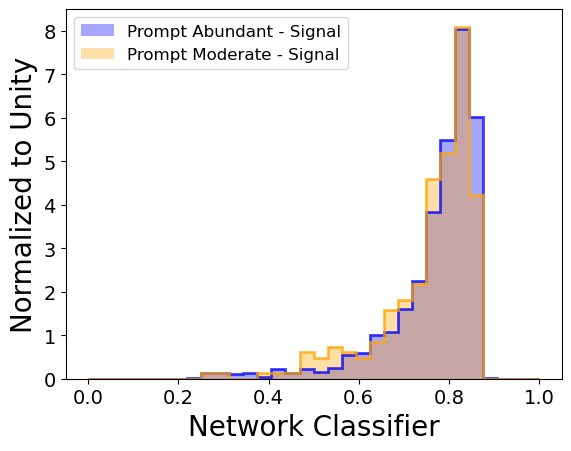

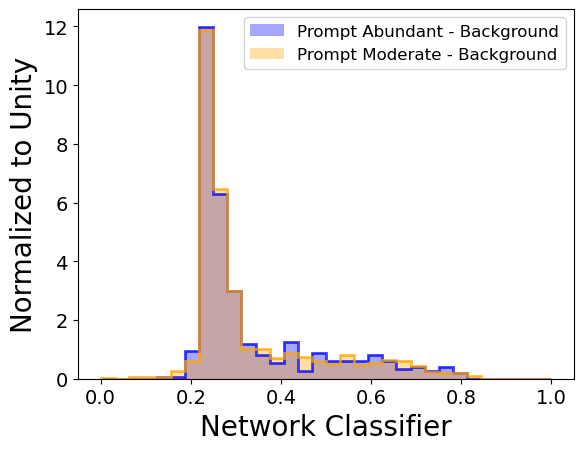

In [92]:
hist_ab(test_outs[mix_bools&(test_true_labels==1)], test_outs[np.invert(mix_bools)&(test_true_labels==1)],
    bins=32, range=[0,1], 
    alabel='Prompt Abundant - Signal', blabel='Prompt Moderate - Signal', xlabel='Network Classifier', 
    ylabel='Normalized to Unity', savename=f'{figure_dir}/sim_nn_sig_only.pdf')
plt.show()
hist_ab(test_outs[mix_bools&(test_true_labels==0)], test_outs[np.invert(mix_bools)&(test_true_labels==0)],
    bins=32, range=[0,1],
    alabel='Prompt Abundant - Background', blabel='Prompt Moderate - Background', xlabel='Network Classifier', 
    ylabel='Normalized to Unity', savename=f'{figure_dir}/sim_nn_bg_only.pdf')
plt.show()

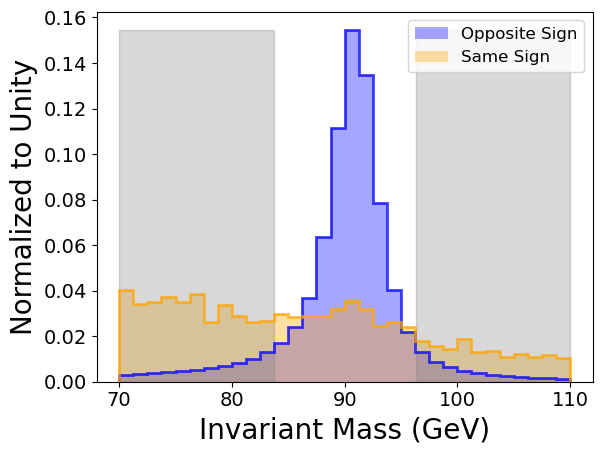

In [93]:
hist_ab(m[os_i], m[ss_i], shaded=[pos_lo,pos_hi],
    bins=32, alabel='Opposite Sign', blabel='Same Sign', 
    xlabel='Invariant Mass (GeV)', ylabel='Normalized to Unity', savename=f'{figure_dir}/mass_osss_shaded.pdf')
plt.show()

In [7]:
env = lmdb.open('src/data/pfn',readonly=True)
txn = env.begin()
sig_reps = np.empty((len(sig_i),128,4))
bg_reps = np.empty((len(bg_i),128,4))
for i,j in enumerate(sig_i):
    sig_reps[i] = np.frombuffer(txn.get(str(j).encode())).reshape((128,4))
for i,j in enumerate(bg_i):
    bg_reps[i] = np.frombuffer(txn.get(str(j).encode())).reshape((128,4))
env.close()

In [67]:
num_objs = []
for i in range(len(sig_reps)):
    num_objs.append(np.sum(sig_reps[i,:,0] > 0))
for i in range(len(bg_reps)):
    num_objs.append(np.sum(bg_reps[i,:,0] > 0))
print(np.max(num_objs), np.mean(num_objs))

124 16.15474550534612


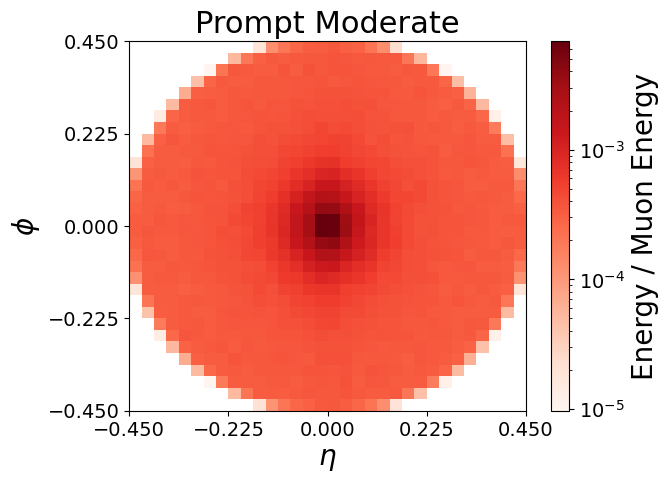

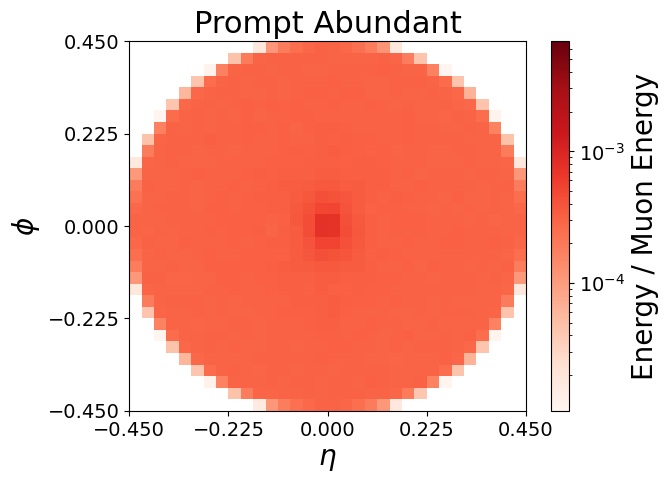

In [74]:
fig,ax = plt.subplots()
bg_h,_,_,im = ax.hist2d(bg_reps[:,:,1].flatten(),bg_reps[:,:,2].flatten(),
                        weights=(bg_reps[:,:,0]/pT[bg_i,0,None]).flatten()/len(bg_reps[:,:,0]),
                        range=[[-0.45,0.45],[-0.45,0.45]],bins=32,cmap='Reds',
                        density=False,norm=mpl.colors.LogNorm())
ax.set_title('Prompt Moderate',fontsize=title_fontsize)
ax.set_xticks([-0.45,-0.225,0,0.225,0.45])
ax.set_yticks([-0.45,-0.225,0,0.225,0.45])
ax.set_xlabel(r'$\eta$',fontsize=label_fontsize)
ax.set_ylabel(r'$\phi$',fontsize=label_fontsize)
ax.tick_params(labelsize=tick_fontsize)
cb = fig.colorbar(im)
cb.set_label(label='Energy / Muon Energy',fontsize=label_fontsize)
cb.ax.tick_params(labelsize=tick_fontsize)
fig.savefig(f'{figure_dir}/non_prompt_avg.pdf',bbox_inches='tight')
plt.show()
vmax = bg_h.max()
fig,ax = plt.subplots()
sig_h,_,_,im = ax.hist2d(sig_reps[:,:,1].flatten(),sig_reps[:,:,2].flatten(),
                         weights=(sig_reps[:,:,0]/pT[sig_i,0,None]).flatten()/len(sig_reps[:,:,0]),
                         range=[[-0.45,0.45],[-0.45,0.45]],bins=32,cmap='Reds',
                         density=False,norm=mpl.colors.LogNorm(vmax=vmax))
ax.set_title('Prompt Abundant',fontsize=title_fontsize)
ax.set_xticks([-0.45,-0.225,0,0.225,0.45])
ax.set_yticks([-0.45,-0.225,0,0.225,0.45])
ax.set_xlabel(r'$\eta$',fontsize=label_fontsize)
ax.set_ylabel(r'$\phi$',fontsize=label_fontsize)
ax.tick_params(labelsize=tick_fontsize)
cb = fig.colorbar(im)
cb.set_label(label='Energy / Muon Energy',fontsize=label_fontsize)
cb.ax.tick_params(labelsize=tick_fontsize)
fig.savefig(f'{figure_dir}/prompt_avg.pdf',bbox_inches='tight')
plt.show()

In [25]:
def exp_dist(x, tau):
    return np.exp(-x/tau)

def voigt_exp_dist(x, tau, alpha, gamma, s):
    voigt = voigt_profile(x-90.8, alpha, gamma)
    voigt = voigt / np.trapz(voigt,x=x)
    exp = exp_dist(x, tau)
    exp = exp / np.trapz(exp,x=x)
    return s*voigt + (1.-s)*exp

def fit_Ms(fit_masses, initial_guess):
    # Determine appropriate number of bins
    q75, q25 = np.percentile(fit_masses, [75 ,25])
    iqr = q75 - q25
    bin_width = 2*iqr*len(fit_masses)**(-1/3)
    num_bins = int((np.max(fit_masses) - np.min(fit_masses)) / bin_width)

    # Make histogram
    mass_hist, bin_edges = np.histogram(fit_masses, bins=num_bins, density=True)

    # Get values at centers of bins
    window_centered = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Perform fit
    # popt in order: (0) exp_lam, (1) exp_const, (2) exp_scale, (3) voigt_sig, (4) voigt_gam, (5) voigt_mass, (6) norm, (7) sig_frac
    bounds_lo = (0, 0, 0, 0)
    bounds_hi = (50.0, 2, 2, 1)
    popt, pcov = curve_fit(voigt_exp_dist, window_centered, mass_hist, p0=initial_guess, 
                           bounds=(bounds_lo, bounds_hi), maxfev=5000)

    # Calculate error on fit parameters
    perr = np.sqrt(np.diag(pcov))
    
    return popt, perr

[14.98708098  0.8638747   1.71483875  0.95618555]
[3.57677566 0.03195844 0.03214047 0.00622222]


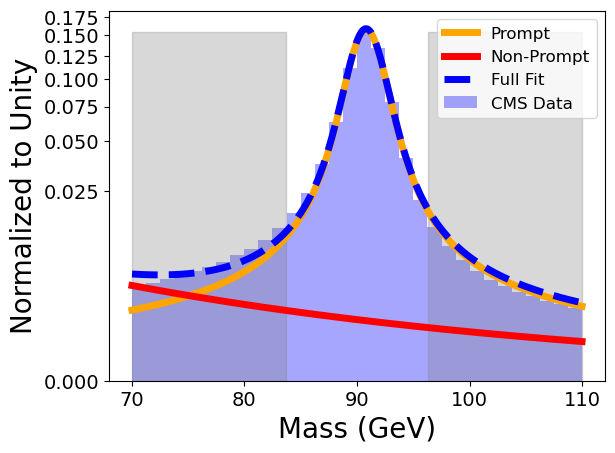

In [128]:
fit_masses = m[np.concatenate([sig_i,bg_i])]
q75, q25 = np.percentile(fit_masses, [75 ,25])
iqr = q75 - q25
bin_width = 2*iqr*len(fit_masses)**(-1/3)
num_bins = int((np.max(fit_masses) - np.min(fit_masses)) / bin_width)

# Make histogram
mass_hist, bin_edges = np.histogram(fit_masses, bins=num_bins, density=True)

# Get values at centers of bins
window_centered = (bin_edges[:-1] + bin_edges[1:]) / 2
initial_guess = [15, 1.5, 1.1, 0.8]
popt, perr = fit_Ms(fit_masses, initial_guess)
print(popt)
print(perr)
voigt = voigt_profile(window_centered-90.8, popt[1], popt[2])
voigt = voigt / np.trapz(voigt,x=window_centered)
exp = exp_dist(window_centered, popt[0])
exp = exp / np.trapz(exp,x=window_centered)
full_fit = popt[-1]*voigt + (1.-popt[-1])*exp
sorter = np.argsort(window_centered)
fig,ax = plt.subplots()
ax.plot(window_centered[sorter],popt[-1]*voigt[sorter],label='Prompt',
    linewidth=5,color='orange')
ax.plot(window_centered[sorter],(1-popt[-1])*exp[sorter],label='Non-Prompt',
    linewidth=5,color='red')
ax.plot(window_centered[sorter],full_fit[sorter],label='Full Fit',
    linewidth=5, color='blue', linestyle='dashed')
h,bins,_,=ax.hist(fit_masses,bins=32,density=True,label='CMS Data',
    color='blue',alpha=0.35)
min_mass = fit_masses.min()
max_mass = fit_masses.max()
max_count = h.max()
x_lo = np.linspace(min_mass,pos_lo)
x_hi = np.linspace(pos_hi,max_mass)
ax.fill_between(x_lo,0,max_count,where=(x_lo<pos_lo),color='grey',alpha=0.3)
ax.fill_between(x_hi,0,max_count,where=(x_hi>pos_hi),color='grey',alpha=0.3)
ax.set_xlabel('Mass (GeV)',fontsize=label_fontsize)
ax.set_ylabel('Normalized to Unity',fontsize=label_fontsize)
ax.tick_params(labelsize=tick_fontsize)
ax.set_yscale('function',functions=(lambda x: x**(1/3), lambda x: x**(3)))
ax.legend(fontsize=legend_fontsize)
fig.savefig(f'{figure_dir}/mass_fit.pdf',bbox_inches='tight')
plt.show()

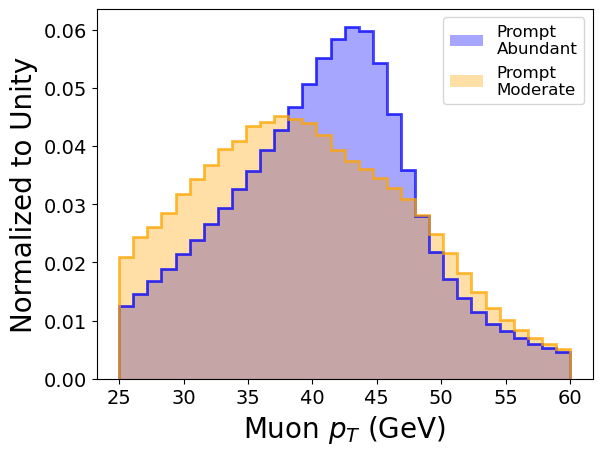

In [76]:
hist_ab(pT[sig_i].flatten(), pT[bg_i].flatten(), range=[25,60],
    bins=32, alabel=r'Prompt''\n''Abundant', blabel='Prompt''\n''Moderate', 
    xlabel='Muon $p_T$ (GeV)', ylabel='Normalized to Unity', savename=f'{figure_dir}/muon_pT.pdf')
plt.show()

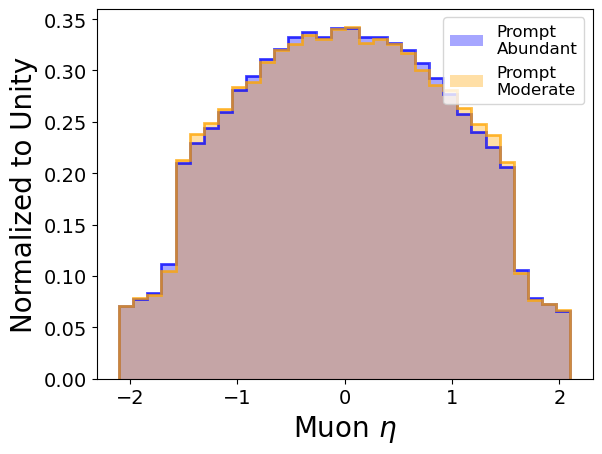

In [75]:
hist_ab(eta[sig_i].flatten(), eta[bg_i].flatten(),
    bins=32, alabel=r'Prompt''\n''Abundant', blabel='Prompt''\n''Moderate', 
    xlabel='Muon $\eta$', ylabel='Normalized to Unity', savename=f'{figure_dir}/muon_eta.pdf')
plt.show()

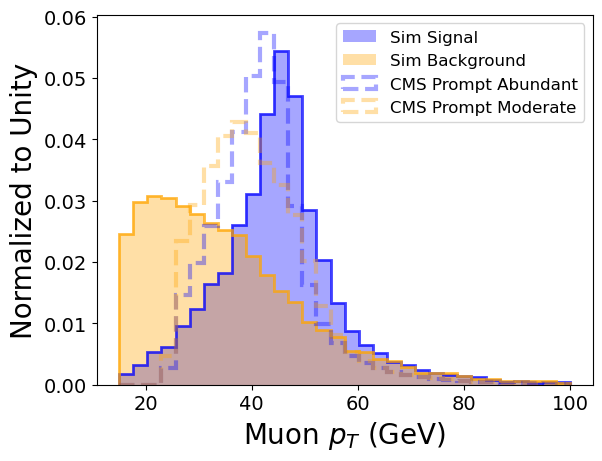

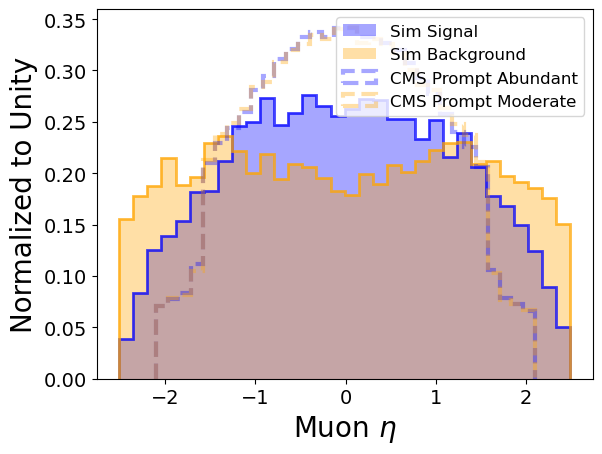

In [124]:
hist_abcd(sim_muon_pT[sim_label==1], sim_muon_pT[sim_label==0], pT[sig_i].flatten(), pT[bg_i].flatten(),
    bins=32, range=[15,100],
    alabel='Sim Signal', blabel='Sim Background', clabel='CMS Prompt Abundant', dlabel='CMS Prompt Moderate',
    xlabel='Muon $p_T$ (GeV)', ylabel='Normalized to Unity', savename=f'{figure_dir}/sim_CMS_compare_muon_pT.pdf')
plt.show()
hist_abcd(sim_muon_eta[sim_label==1], sim_muon_eta[sim_label==0], eta[sig_i].flatten(), eta[bg_i].flatten(),
    bins=32, 
    alabel='Sim Signal', blabel='Sim Background', clabel='CMS Prompt Abundant', dlabel='CMS Prompt Moderate',
    xlabel='Muon $\eta$', ylabel='Normalized to Unity', savename=f'{figure_dir}/sim_CMS_compare_muon_eta.pdf')
plt.show()

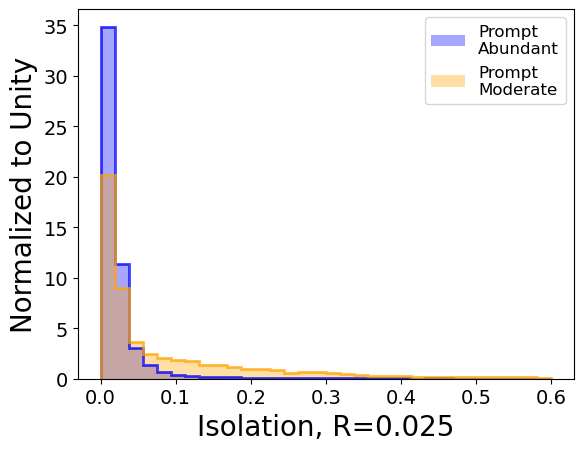

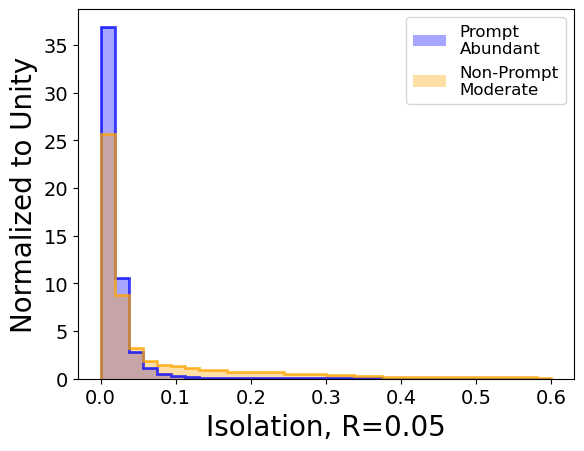

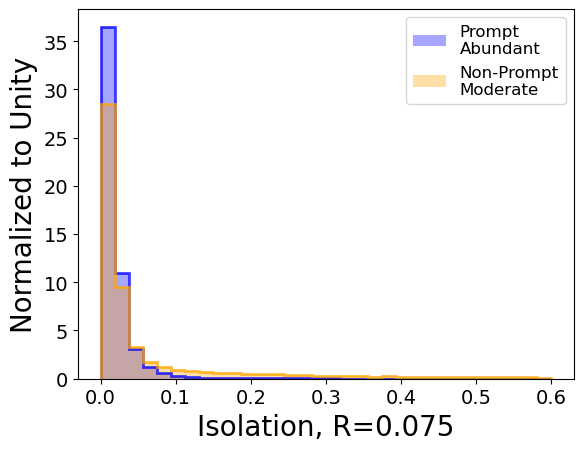

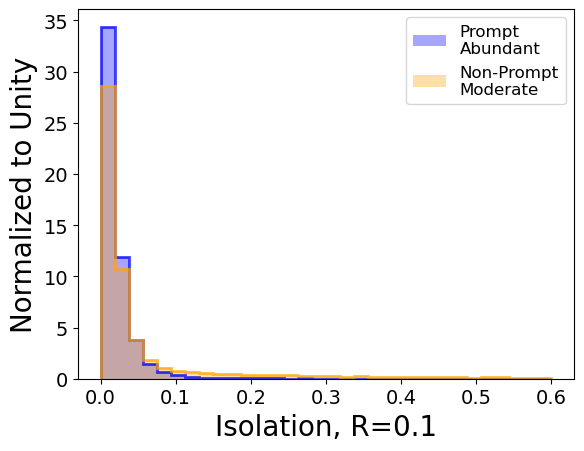

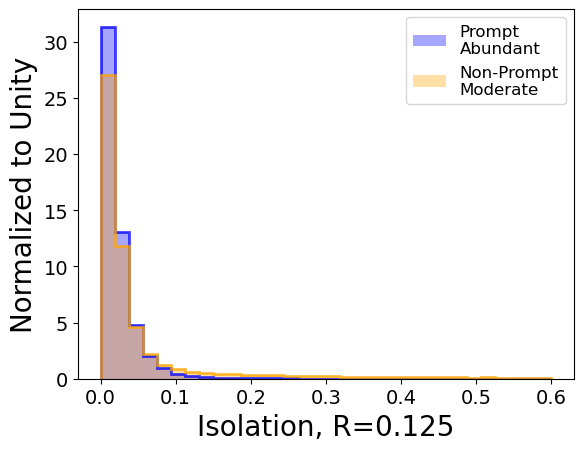

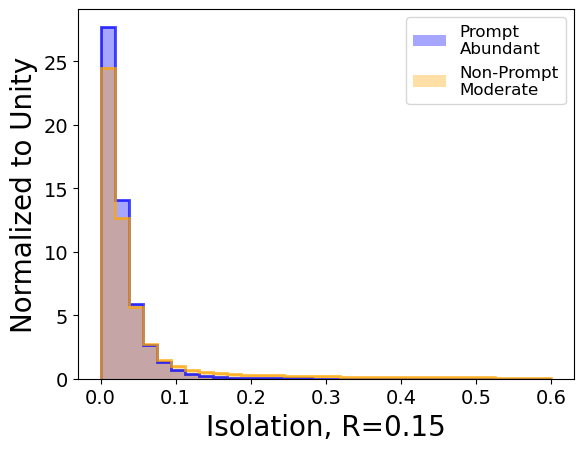

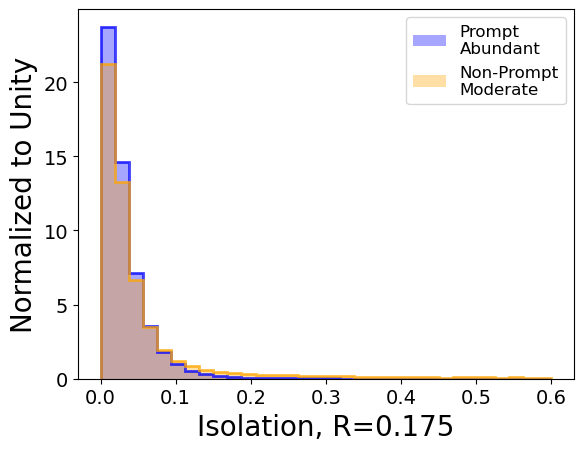

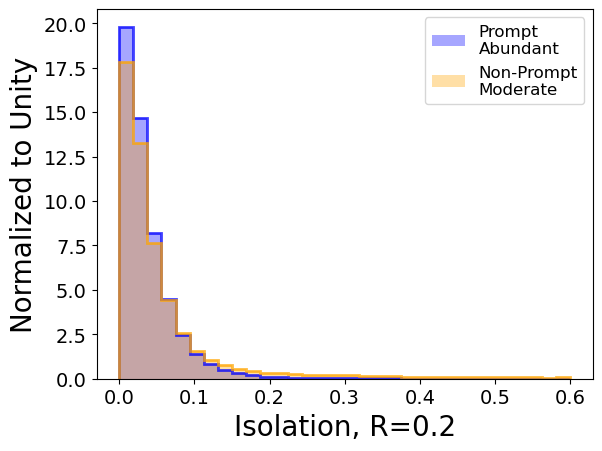

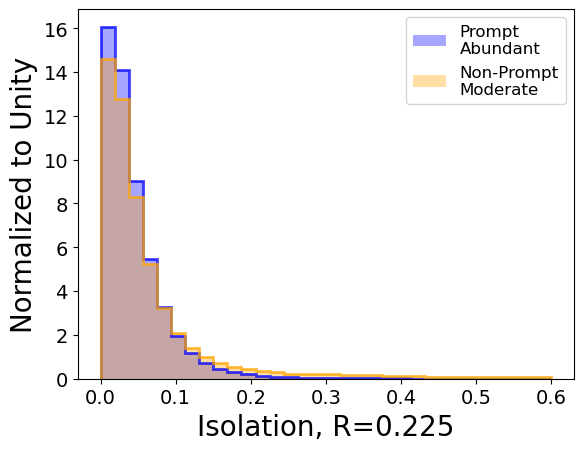

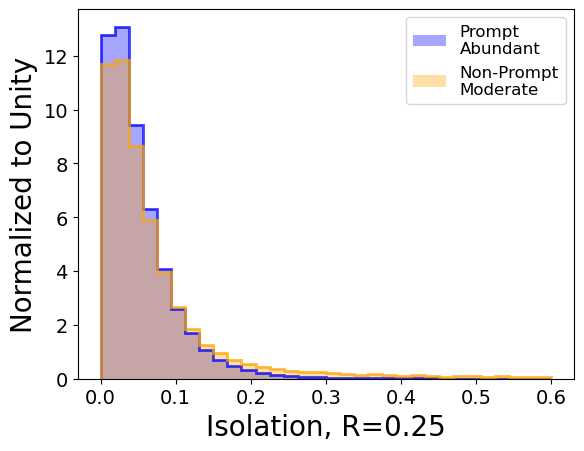

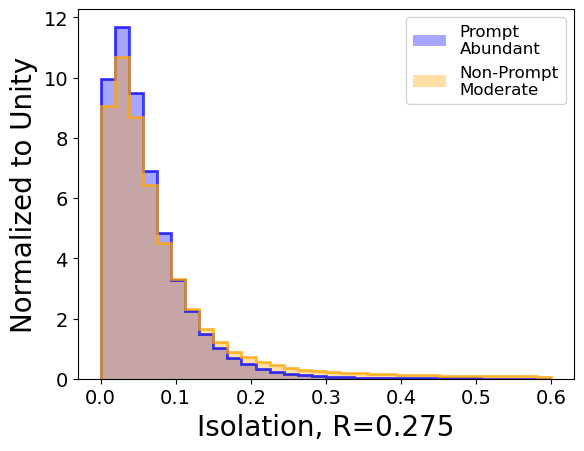

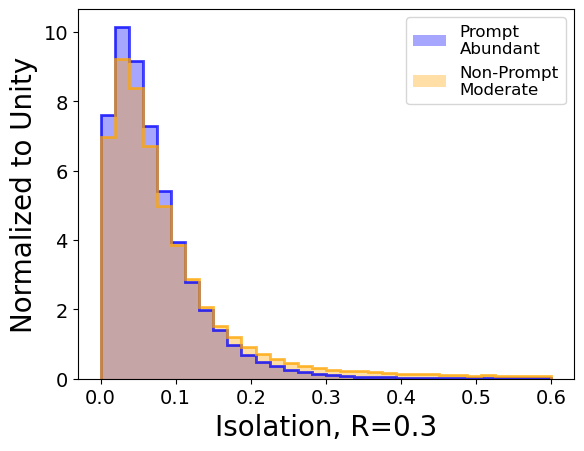

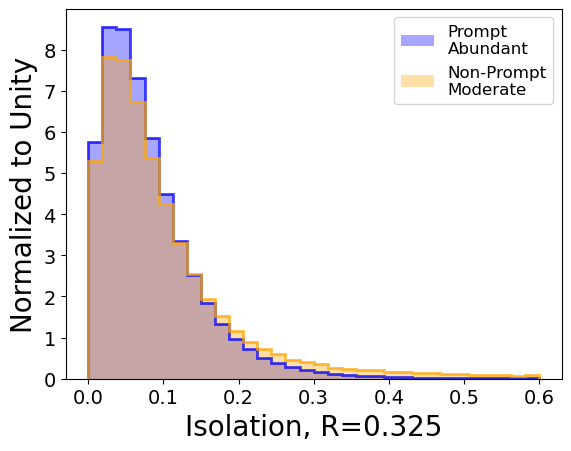

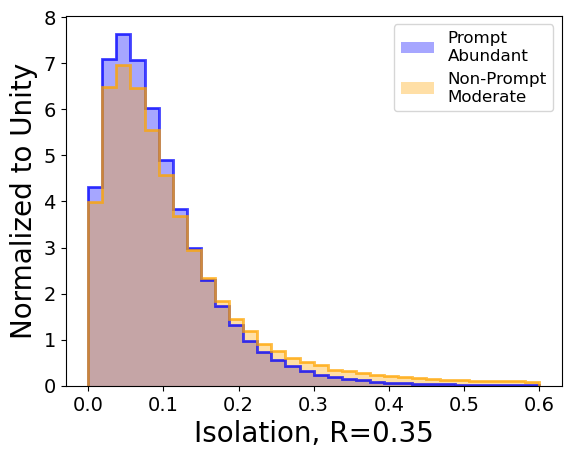

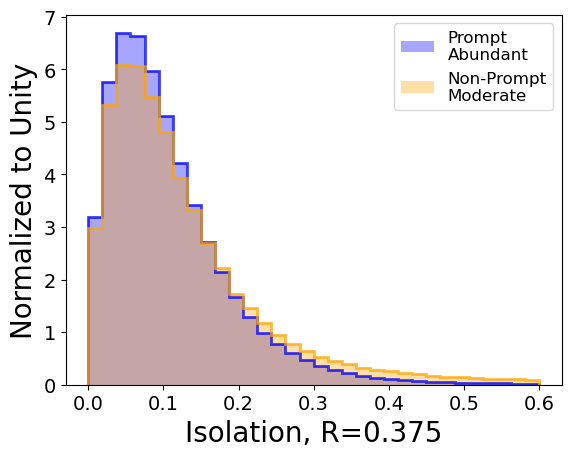

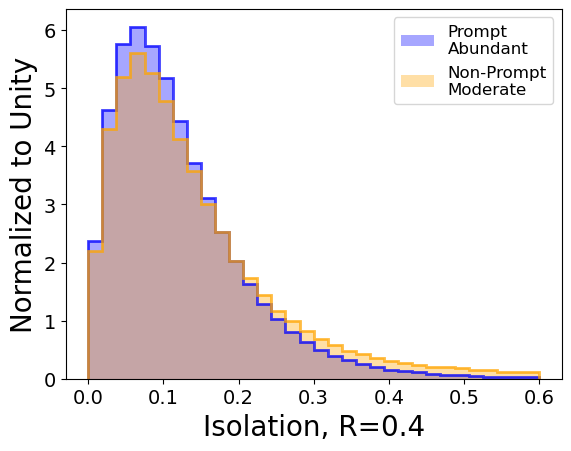

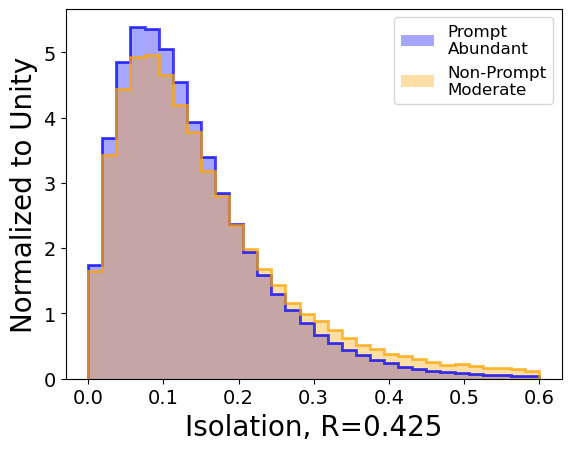

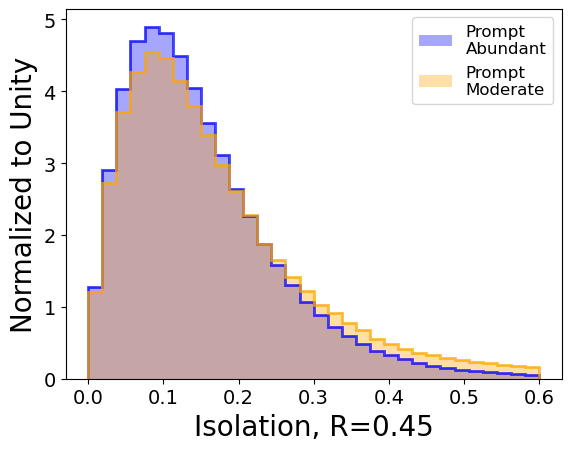

In [80]:
env = lmdb.open('src/data/iso',readonly=True)
txn = env.begin()
cms_cones = np.empty((env.stat()['entries'],18))
for i in range(len(cms_cones)):
    cms_cones[i] = np.frombuffer(txn.get(str(i).encode()))
radii = np.around(np.linspace(0.025,0.45,18),decimals=3)
cone_sig_idx = sig_i
cone_bg_idx = bg_i
for i in range(18):
    sig_cones = cms_cones[cone_sig_idx][:,i].flatten()
    sig_cones = sig_cones[sig_cones>0]
    bg_cones = cms_cones[cone_bg_idx][:,i].flatten()
    bg_cones = bg_cones[bg_cones>0]
    if (i==0) or (i==17):
        hist_ab(sig_cones, bg_cones, range=[0,0.6],
            bins=32, alabel=r'Prompt''\n''Abundant', blabel='Prompt''\n''Moderate', 
            xlabel=f'Isolation, R={radii[i]}', ylabel='Normalized to Unity',savename=f'{figure_dir}/iso_{i}_cwola.pdf')
    else:
        hist_ab(sig_cones, bg_cones, range=[0,0.6],
            bins=32, alabel=r'Prompt''\n''Abundant', blabel='Non-Prompt''\n''Moderate', 
            xlabel=f'Isolation, R={radii[i]}', ylabel='Normalized to Unity')
    plt.show()
env.close()

In [39]:
e = lmdb.open('src/data/cms_efp_k1.0_b0.25',readonly=True)
t = e.begin()
full_index = np.concatenate([train_index,valid_index,test_index])
sig_idx = full_index[np.argwhere(label[full_index]==1).squeeze()]
bg_idx = full_index[np.argwhere(label[full_index]==0).squeeze()]
sig_efp = np.empty(len(sig_idx))
bg_efp = np.empty(len(bg_idx))
for i,idx in enumerate(sig_idx):
    sig_efp[i] = np.frombuffer(t.get(str(idx).encode()))[93]
for i,idx in enumerate(bg_idx):
    bg_efp[i] = np.frombuffer(t.get(str(idx).encode()))[93]

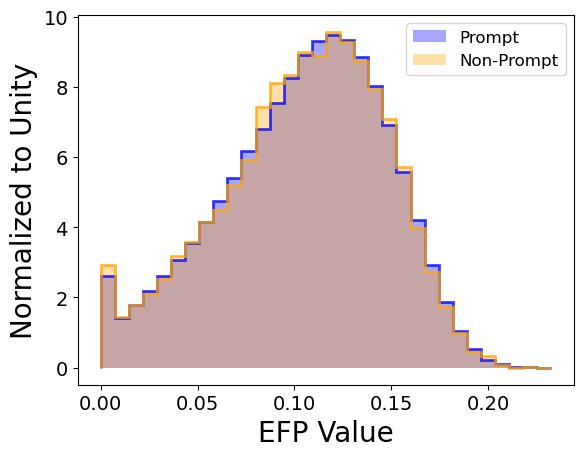

In [120]:
efp = np.concatenate([sig_efp,bg_efp])

q75, q25 = np.percentile(efp, [75 ,25])
iqr = q75 - q25
bin_width = 2*iqr*len(efp)**(-1/3)
num_bins = int((np.max(efp) - np.min(efp)) / bin_width)

sort = np.argsort(m[full_index])
masses = m[full_index][sort]
efp = efp[sort]

initial_guess = [15, 1.5, 1.1, 0.8]
popt, perr = fit_Ms(masses, initial_guess)

exp = exp_dist(masses, popt[0])
voigt = voigt_profile(masses - 90.8, popt[1], popt[2])
exp = (1.-popt[-1])*(exp / np.trapz(exp, x=masses))
voigt = popt[-1]*(voigt / np.trapz(voigt, x=masses))

voigt_probs = voigt / (voigt + exp)
exp_probs = exp / (voigt + exp)

probs = pd.DataFrame(dict(sig=voigt_probs, bck=exp_probs))
if np.allclose(probs.sum(axis=1), 1, atol=1e-3):
    sWeights = splot.compute_sweights(probs)

    hist_ab(efp, efp, a_weight=sWeights.sig, b_weight=sWeights.bck, 
        bins=num_bins, alabel=r'Prompt', blabel='Non-Prompt', 
        xlabel='EFP Value', ylabel='Normalized to Unity',savename=f'{figure_dir}/selected_efp_splot_dist.pdf')
    plt.show()

In [7]:
def exp_dist(x, tau):
    return np.exp(-x/tau)

def voigt_exp_dist(x, tau, alpha, gamma, s):
    voigt = voigt_profile(x-90.8, alpha, gamma)
    voigt = voigt / np.trapz(voigt,x=x)
    exp = exp_dist(x, tau)
    exp = exp / np.trapz(exp,x=x)
    return s*voigt + (1.-s)*exp

def fit_Ms(fit_masses, initial_guess):
    # Determine appropriate number of bins
    q75, q25 = np.percentile(fit_masses, [75 ,25])
    iqr = q75 - q25
    bin_width = 2*iqr*len(fit_masses)**(-1/3)
    num_bins = int((np.max(fit_masses) - np.min(fit_masses)) / bin_width)

    # Make histogram
    mass_hist, bin_edges = np.histogram(fit_masses, bins=num_bins, density=True)

    # Get values at centers of bins
    window_centered = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Perform fit
    # popt in order: (0) exp_lam, (1) exp_const, (2) exp_scale, (3) voigt_sig, (4) voigt_gam, (5) voigt_mass, (6) norm, (7) sig_frac
    bounds_lo = (0, 0, 0, 0)
    bounds_hi = (50.0, 2, 2, 1)
    popt, pcov = curve_fit(voigt_exp_dist, window_centered, mass_hist, p0=initial_guess, 
                           bounds=(bounds_lo, bounds_hi), maxfev=5000)

    # Calculate error on fit parameters
    perr = np.sqrt(np.diag(pcov))
    
    return popt, perr, pcov

In [19]:
def calc_weak_roc_splot(masses, outs, num_bins=None, sample_seed=None):

    sort = np.argsort(masses)
    masses = masses[sort]
    outs = outs[sort]
    
    initial_guess = [15, 1.5, 1.1, 0.8]
    popt, perr, pcov = fit_Ms(masses, initial_guess)

    if sample_seed is not None:
        L = np.linalg.cholesky(pcov)
        np.random.seed(sample_seed)
        randn = np.random.randn(len(popt))
        popt = popt + L.dot(randn)
    
    if num_bins is None:
        q75, q25 = np.percentile(outs, [75 ,25])
        iqr = q75 - q25
        bin_width = (2*iqr*((1-popt[-1])*len(outs))**(-1/3))
        num_bins = int(np.ceil((np.max(outs) - np.min(outs)) / bin_width))
    
    exp = exp_dist(masses, popt[0])
    voigt = voigt_profile(masses - 90.8, popt[1], popt[2])
    exp = (1.-popt[-1])*(exp / np.trapz(exp, x=masses))
    voigt = popt[-1]*(voigt / np.trapz(voigt, x=masses))
    
    voigt_probs = voigt / (voigt + exp)
    exp_probs = exp / (voigt + exp)
    
    probs = pd.DataFrame(dict(sig=voigt_probs, bck=exp_probs))
    if np.allclose(probs.sum(axis=1), 1, atol=1e-3):
        sWeights = splot.compute_sweights(probs)
    
        sig_hist, bin_edges = np.histogram(outs, weights=sWeights.sig, bins=num_bins)
        bg_hist, _ = np.histogram(outs, weights=sWeights.bck, bins=bin_edges)
    
        sig_hist[sig_hist<0] = 0
        bg_hist[bg_hist<0] = 0
        
        fpr = []
        tpr = []
        for i,t in enumerate(bin_edges):
            fpr.append(np.sum(bg_hist[i:])/np.sum(bg_hist))
            tpr.append(np.sum(sig_hist[i:])/np.sum(sig_hist))
            
        _, unique_i = np.unique(fpr,return_index=True)
        unique_i = unique_i[::-1]
        fpr = np.array(fpr)[unique_i]
        tpr = np.array(tpr)[unique_i]
        bin_edges = np.array(bin_edges)[unique_i]
    else:
        fpr = np.array([0,0.5,1])
        tpr = np.array([0,0.5,1])
        bin_edges = np.array([0,0.5,1])
        
    return fpr, tpr, bin_edges

In [23]:
experiment_dir = './cross_validation/iso_pT/lightning_logs'
pfn_dir = './bootstrapping/pfn/lightning_logs'
efp_dir = './bootstrapping/single_iso_pT_efp/lightning_logs'
quad_efp_dir = './bootstrapping/quadratic_iso_pT_efp/lightning_logs'
safe_efp_dir = './bootstrapping/simsafe_iso_pT_efp/lightning_logs'
unsafe_efp_dir = './bootstrapping/simunsafe_iso_pT_efp/lightning_logs'
iso1_dir = './bootstrapping/iso_pT_1/lightning_logs'
iso9_dir = './bootstrapping/iso_pT_9/lightning_logs'
num_folds = 5
num_cones = 18
num_fit_bootstraps = 100
num_pfn_bootstraps = 100
num_efp_bootstraps = 100
num_iso_bootstraps = 100
num_gpus = 4
n_bins = None#300#400

pfn_fprs = [[] for _ in range(num_pfn_bootstraps)]
pfn_tprs = [[] for _ in range(num_pfn_bootstraps)]
pfn_threshs = [[] for _ in range(num_pfn_bootstraps)]
pfn_aucs = [[] for _ in range(num_pfn_bootstraps)]
for i in range(num_pfn_bootstraps):
    print('\r'*100,end='')
    print(f'Processing bootstrap {i}/{num_pfn_bootstraps}\r',end='')
    bootstrap_dir = f'{pfn_dir}/trainsize_1.0_bootstrap_{i}'

    test_idx = []
    test_outs = []
    test_masses= []
    for j in range(num_gpus):
        test_idx.append(np.load(f'{bootstrap_dir}/test_idx_cuda:{j}.npy'))
        test_outs.append(np.load(f'{bootstrap_dir}/test_outs_cuda:{j}.npy'))
        test_masses.append(np.load(f'{bootstrap_dir}/test_masses_cuda:{j}.npy'))
    test_idx = np.concatenate(test_idx).flatten()
    test_idx, unique_filter = np.unique(test_idx,return_index=True)
    test_outs = np.concatenate(test_outs).flatten()[unique_filter]
    test_masses = np.concatenate(test_masses).flatten()[unique_filter]

    for k in range(num_fit_bootstraps):
        pfn_fpr, pfn_tpr, pfn_thresh = calc_weak_roc_splot(test_masses, test_outs,
                                                           sample_seed=k, num_bins=n_bins)
        pfn_fprs[i].append(pfn_fpr)
        pfn_tprs[i].append(pfn_tpr)
        pfn_threshs[i].append(pfn_thresh)
        pfn_aucs[i].append(auc(pfn_fpr,pfn_tpr))

pfn_reduced_aucs = np.mean(pfn_aucs,axis=1)
auc_avg_pfn = np.mean(pfn_reduced_aucs)
auc_std_pfn = np.std(pfn_reduced_aucs, ddof=1)
auc_se_pfn = auc_std_pfn/np.sqrt(num_pfn_bootstraps)
print('')
print('PFN')
print(f'Average AUC: {auc_avg_pfn}, Error: {auc_se_pfn}')

quad_efp_fprs = [[] for _ in range(num_efp_bootstraps)]
quad_efp_tprs = [[] for _ in range(num_efp_bootstraps)]
quad_efp_threshs = [[] for _ in range(num_efp_bootstraps)]
quad_efp_aucs = [[] for _ in range(num_efp_bootstraps)]
for i in range(num_efp_bootstraps):
    print('\r'*100,end='')
    print(f'Processing bootstrap {i}/{num_efp_bootstraps}\r',end='')
    bootstrap_dir = f'{quad_efp_dir}/numcones_9_trainsize_1.0_bootstrap_{i}'

    test_idx = []
    test_outs = []
    test_masses= []
    for j in range(num_gpus):
        test_idx.append(np.load(f'{bootstrap_dir}/test_idx_cuda:{j}.npy'))
        test_outs.append(np.load(f'{bootstrap_dir}/test_outs_cuda:{j}.npy'))
        test_masses.append(np.load(f'{bootstrap_dir}/test_masses_cuda:{j}.npy'))
    test_idx = np.concatenate(test_idx).flatten()
    test_idx, unique_filter = np.unique(test_idx,return_index=True)
    test_outs = np.concatenate(test_outs).flatten()[unique_filter]
    test_masses = np.concatenate(test_masses).flatten()[unique_filter]

    for k in range(num_fit_bootstraps):
        quad_efp_fpr, quad_efp_tpr, quad_efp_thresh = calc_weak_roc_splot(test_masses, test_outs,
                                                        sample_seed=k, num_bins=n_bins)
        quad_efp_fprs[i].append(quad_efp_fpr)
        quad_efp_tprs[i].append(quad_efp_tpr)
        quad_efp_threshs[i].append(quad_efp_threshs)
        quad_efp_aucs[i].append(auc(quad_efp_fpr,quad_efp_tpr))

quad_efp_reduced_aucs = np.mean(quad_efp_aucs,axis=1)
auc_avg_quad_efp = np.mean(quad_efp_reduced_aucs)
auc_std_quad_efp = np.std(quad_efp_reduced_aucs, ddof=1)
auc_se_quad_efp = auc_std_quad_efp/np.sqrt(num_efp_bootstraps)
print('')
print('quad EFP')
print(f'Average AUC: {auc_avg_quad_efp}, Error: {auc_se_quad_efp}')

safe_efp_fprs = [[] for _ in range(num_efp_bootstraps)]
safe_efp_tprs = [[] for _ in range(num_efp_bootstraps)]
safe_efp_threshs = [[] for _ in range(num_efp_bootstraps)]
safe_efp_aucs = [[] for _ in range(num_efp_bootstraps)]
for i in range(num_efp_bootstraps):
    print('\r'*100,end='')
    print(f'Processing bootstrap {i}/{num_efp_bootstraps}\r',end='')
    bootstrap_dir = f'{safe_efp_dir}/numcones_9_trainsize_1.0_bootstrap_{i}'

    test_idx = []
    test_outs = []
    test_masses= []
    for j in range(num_gpus):
        test_idx.append(np.load(f'{bootstrap_dir}/test_idx_cuda:{j}.npy'))
        test_outs.append(np.load(f'{bootstrap_dir}/test_outs_cuda:{j}.npy'))
        test_masses.append(np.load(f'{bootstrap_dir}/test_masses_cuda:{j}.npy'))
    test_idx = np.concatenate(test_idx).flatten()
    test_idx, unique_filter = np.unique(test_idx,return_index=True)
    test_outs = np.concatenate(test_outs).flatten()[unique_filter]
    test_masses = np.concatenate(test_masses).flatten()[unique_filter]

    for k in range(num_fit_bootstraps):
        safe_efp_fpr, safe_efp_tpr, safe_efp_thresh = calc_weak_roc_splot(test_masses, test_outs,
                                                        sample_seed=k, num_bins=n_bins)
        safe_efp_fprs[i].append(safe_efp_fpr)
        safe_efp_tprs[i].append(safe_efp_tpr)
        safe_efp_threshs[i].append(safe_efp_threshs)
        safe_efp_aucs[i].append(auc(safe_efp_fpr,safe_efp_tpr))

safe_efp_reduced_aucs = np.mean(safe_efp_aucs,axis=1)
auc_avg_safe_efp = np.mean(safe_efp_reduced_aucs)
auc_std_safe_efp = np.std(safe_efp_reduced_aucs, ddof=1)
auc_se_safe_efp = auc_std_safe_efp/np.sqrt(num_efp_bootstraps)
print('')
print('safe EFP')
print(f'Average AUC: {auc_avg_safe_efp}, Error: {auc_se_safe_efp}')

unsafe_efp_fprs = [[] for _ in range(num_efp_bootstraps)]
unsafe_efp_tprs = [[] for _ in range(num_efp_bootstraps)]
unsafe_efp_threshs = [[] for _ in range(num_efp_bootstraps)]
unsafe_efp_aucs = [[] for _ in range(num_efp_bootstraps)]
for i in range(num_efp_bootstraps):
    print('\r'*100,end='')
    print(f'Processing bootstrap {i}/{num_efp_bootstraps}\r',end='')
    bootstrap_dir = f'{unsafe_efp_dir}/numcones_9_trainsize_1.0_bootstrap_{i}'

    test_idx = []
    test_outs = []
    test_masses= []
    for j in range(num_gpus):
        test_idx.append(np.load(f'{bootstrap_dir}/test_idx_cuda:{j}.npy'))
        test_outs.append(np.load(f'{bootstrap_dir}/test_outs_cuda:{j}.npy'))
        test_masses.append(np.load(f'{bootstrap_dir}/test_masses_cuda:{j}.npy'))
    test_idx = np.concatenate(test_idx).flatten()
    test_idx, unique_filter = np.unique(test_idx,return_index=True)
    test_outs = np.concatenate(test_outs).flatten()[unique_filter]
    test_masses = np.concatenate(test_masses).flatten()[unique_filter]

    for k in range(num_fit_bootstraps):
        unsafe_efp_fpr, unsafe_efp_tpr, unsafe_efp_thresh = calc_weak_roc_splot(test_masses, test_outs,
                                                                sample_seed=k, num_bins=n_bins)
        unsafe_efp_fprs[i].append(unsafe_efp_fpr)
        unsafe_efp_tprs[i].append(unsafe_efp_tpr)
        unsafe_efp_threshs[i].append(unsafe_efp_threshs)
        unsafe_efp_aucs[i].append(auc(unsafe_efp_fpr,unsafe_efp_tpr))

unsafe_efp_reduced_aucs = np.mean(unsafe_efp_aucs,axis=1)
auc_avg_unsafe_efp = np.mean(unsafe_efp_reduced_aucs)
auc_std_unsafe_efp = np.std(unsafe_efp_reduced_aucs, ddof=1)
auc_se_unsafe_efp = auc_std_unsafe_efp/np.sqrt(num_efp_bootstraps)
print('')
print('unsafe EFP')
print(f'Average AUC: {auc_avg_unsafe_efp}, Error: {auc_se_unsafe_efp}')

efp_fprs = [[] for _ in range(num_efp_bootstraps)]
efp_tprs = [[] for _ in range(num_efp_bootstraps)]
efp_threshs = [[] for _ in range(num_efp_bootstraps)]
efp_aucs = [[] for _ in range(num_efp_bootstraps)]
for i in range(num_efp_bootstraps):
    print('\r'*100,end='')
    print(f'Processing bootstrap {i}/{num_efp_bootstraps}\r',end='')
    bootstrap_dir = f'{efp_dir}/numcones_9_trainsize_1.0_bootstrap_{i}'

    test_idx = []
    test_outs = []
    test_masses= []
    for j in range(num_gpus):
        test_idx.append(np.load(f'{bootstrap_dir}/test_idx_cuda:{j}.npy'))
        test_outs.append(np.load(f'{bootstrap_dir}/test_outs_cuda:{j}.npy'))
        test_masses.append(np.load(f'{bootstrap_dir}/test_masses_cuda:{j}.npy'))
    test_idx = np.concatenate(test_idx).flatten()
    test_idx, unique_filter = np.unique(test_idx,return_index=True)
    test_outs = np.concatenate(test_outs).flatten()[unique_filter]
    test_masses = np.concatenate(test_masses).flatten()[unique_filter]

    for k in range(num_fit_bootstraps):
        efp_fpr, efp_tpr, efp_thresh = calc_weak_roc_splot(test_masses, test_outs,
                                                        sample_seed=k, num_bins=n_bins)
        efp_fprs[i].append(efp_fpr)
        efp_tprs[i].append(efp_tpr)
        efp_threshs[i].append(efp_threshs)
        efp_aucs[i].append(auc(efp_fpr,efp_tpr))

efp_reduced_aucs = np.mean(efp_aucs,axis=1)
auc_avg_efp = np.mean(efp_reduced_aucs)
auc_std_efp = np.std(efp_reduced_aucs, ddof=1)
auc_se_efp = auc_std_efp/np.sqrt(num_efp_bootstraps)
print('')
print('single EFP')
print(f'Average AUC: {auc_avg_efp}, Error: {auc_se_efp}')

iso_1_fprs = [[] for _ in range(num_iso_bootstraps)]
iso_1_tprs = [[] for _ in range(num_iso_bootstraps)]
iso_1_threshs = [[] for _ in range(num_iso_bootstraps)]
iso_1_aucs = [[] for _ in range(num_iso_bootstraps)]
for i in range(num_iso_bootstraps):
    print('\r'*100,end='')
    print(f'Processing bootstrap {i}/{num_iso_bootstraps}\r',end='')
    bootstrap_dir = f'{iso1_dir}/numcones_1_trainsize_1.0_bootstrap_{i}'

    test_idx = []
    test_outs = []
    test_masses= []
    for j in range(num_gpus):
        test_idx.append(np.load(f'{bootstrap_dir}/test_idx_cuda:{j}.npy'))
        test_outs.append(np.load(f'{bootstrap_dir}/test_outs_cuda:{j}.npy'))
        test_masses.append(np.load(f'{bootstrap_dir}/test_masses_cuda:{j}.npy'))
    test_idx = np.concatenate(test_idx).flatten()
    test_idx, unique_filter = np.unique(test_idx,return_index=True)
    test_outs = np.concatenate(test_outs).flatten()[unique_filter]
    test_masses = np.concatenate(test_masses).flatten()[unique_filter]

    for k in range(num_fit_bootstraps):
        iso_1_fpr, iso_1_tpr, iso_1_thresh = calc_weak_roc_splot(test_masses, test_outs,
                                                                sample_seed=k, num_bins=n_bins)
        iso_1_fprs[i].append(iso_1_fpr)
        iso_1_tprs[i].append(iso_1_tpr)
        iso_1_threshs[i].append(iso_1_threshs)
        iso_1_aucs[i].append(auc(iso_1_fpr,iso_1_tpr))

iso_1_reduced_aucs = np.mean(iso_1_aucs,axis=1)
auc_avg_iso_1 = np.mean(iso_1_reduced_aucs)
auc_std_iso_1 = np.std(iso_1_reduced_aucs, ddof=1)
auc_se_iso_1 = auc_std_iso_1/np.sqrt(num_iso_bootstraps)
print('')
print('single Iso')
print(f'Average AUC: {auc_avg_iso_1}, Error: {auc_se_iso_1}')

iso_9_fprs = [[] for _ in range(num_iso_bootstraps)]
iso_9_tprs = [[] for _ in range(num_iso_bootstraps)]
iso_9_threshs = [[] for _ in range(num_iso_bootstraps)]
iso_9_aucs = [[] for _ in range(num_iso_bootstraps)]
for i in range(num_iso_bootstraps):
    print('\r'*100,end='')
    print(f'Processing bootstrap {i}/{num_iso_bootstraps}\r',end='')
    bootstrap_dir = f'{iso9_dir}/numcones_9_trainsize_1.0_bootstrap_{i}'

    test_idx = []
    test_outs = []
    test_masses= []
    for j in range(num_gpus):
        test_idx.append(np.load(f'{bootstrap_dir}/test_idx_cuda:{j}.npy'))
        test_outs.append(np.load(f'{bootstrap_dir}/test_outs_cuda:{j}.npy'))
        test_masses.append(np.load(f'{bootstrap_dir}/test_masses_cuda:{j}.npy'))
    test_idx = np.concatenate(test_idx).flatten()
    test_idx, unique_filter = np.unique(test_idx,return_index=True)
    test_outs = np.concatenate(test_outs).flatten()[unique_filter]
    test_masses = np.concatenate(test_masses).flatten()[unique_filter]

    for k in range(num_fit_bootstraps):
        iso_9_fpr, iso_9_tpr, iso_9_thresh = calc_weak_roc_splot(test_masses, test_outs,
                                                                sample_seed=k, num_bins=n_bins)
        iso_9_fprs[i].append(iso_9_fpr)
        iso_9_tprs[i].append(iso_9_tpr)
        iso_9_threshs[i].append(iso_9_threshs)
        iso_9_aucs[i].append(auc(iso_9_fpr,iso_9_tpr))

iso_9_reduced_aucs = np.mean(iso_9_aucs,axis=1)
auc_avg_iso_9 = np.mean(iso_9_reduced_aucs)
auc_std_iso_9 = np.std(iso_9_reduced_aucs, ddof=1)
auc_se_iso_9 = auc_std_iso_9/np.sqrt(num_iso_bootstraps)
print('')
print('9 Iso')
print(f'Average AUC: {auc_avg_iso_9}, Error: {auc_se_iso_9}')

iso_fprs = [[[] for _ in range(num_cones)] for _ in range(num_folds)]
iso_tprs = [[[] for _ in range(num_cones)] for _ in range(num_folds)]
iso_threshs = [[[] for _ in range(num_cones)] for _ in range(num_folds)]
iso_aucs = np.empty((num_folds,num_fit_bootstraps,num_cones))
iso_aucs[:,:] = np.nan
for i in range(num_folds):
    for n in np.arange(num_cones)+1: 
        version_dir = f'cross_validation/iso_pT/lightning_logs/numcones_{n}_trainsize_1.0_fold_{i}'
        test_idx = []
        test_labels = []
        test_outs = []
        test_masses= []
        gpus = np.unique([f.split(':')[1][0] 
            for f in os.listdir(version_dir) if ':' in f]).astype(np.int32)
        for j in gpus:
            test_idx.append(np.load(f'{version_dir}/test_idx_cuda:{j}.npy'))
            test_labels.append(np.load(f'{version_dir}/test_labels_cuda:{j}.npy'))
            test_outs.append(np.load(f'{version_dir}/test_outs_cuda:{j}.npy'))
            test_masses.append(np.load(f'{version_dir}/test_masses_cuda:{j}.npy'))
        test_idx = np.concatenate(test_idx).flatten()
        test_idx, unique_filter = np.unique(test_idx,return_index=True)
        test_labels = np.concatenate(test_labels).flatten()[unique_filter]
        test_outs = np.concatenate(test_outs).flatten()[unique_filter]
        test_masses = np.concatenate(test_masses).flatten()[unique_filter]

        for k in range(num_fit_bootstraps):
            iso_fpr, iso_tpr, iso_thresh = calc_weak_roc_splot(test_masses, test_outs,
                                                                sample_seed=k, num_bins=n_bins)
            iso_fprs[i][n-1].append(iso_fpr)
            iso_tprs[i][n-1].append(iso_tpr)
            iso_threshs[i][n-1].append(iso_thresh)
            iso_aucs[i,k,n-1] = auc(iso_fpr,iso_tpr)

iso_reduced_aucs = np.mean(iso_aucs, axis=1)
iso_avg = np.mean(iso_reduced_aucs,axis=0)
iso_std = np.std(iso_reduced_aucs,axis=0)
print('')
print('Iso')
print('AUCs: ', iso_avg)
print('error: ', iso_std)

Processing bootstrap 99/100
PFN
Average AUC: 0.8738230210437935, Error: 0.00032484623861400085
Processing bootstrap 99/100
quad EFP
Average AUC: 0.8703843337108882, Error: 0.0006465235097023247
Processing bootstrap 99/100
safe EFP
Average AUC: 0.8681928876321109, Error: 0.0004674487716892512
Processing bootstrap 99/100
unsafe EFP
Average AUC: 0.8648736056518836, Error: 0.0006200856456406791
Processing bootstrap 99/100
single EFP
Average AUC: 0.8711405250818988, Error: 0.0005977784167237744
Processing bootstrap 99/100
single Iso
Average AUC: 0.8352523250134091, Error: 0.0006444250691179309
Processing bootstrap 99/100
9 Iso
Average AUC: 0.8481478804952414, Error: 0.0006943000047753775

Iso
AUCs:  [0.83181019 0.83290291 0.82939663 0.83549378 0.83759833 0.84229942
 0.84526277 0.84895773 0.85206568 0.8512279  0.85418974 0.85282297
 0.85483257 0.85400449 0.85036789 0.85104049 0.8524553  0.85388776]
error:  [0.00389696 0.00487932 0.00402849 0.0036532  0.00416118 0.00416605
 0.0033486  0.00341

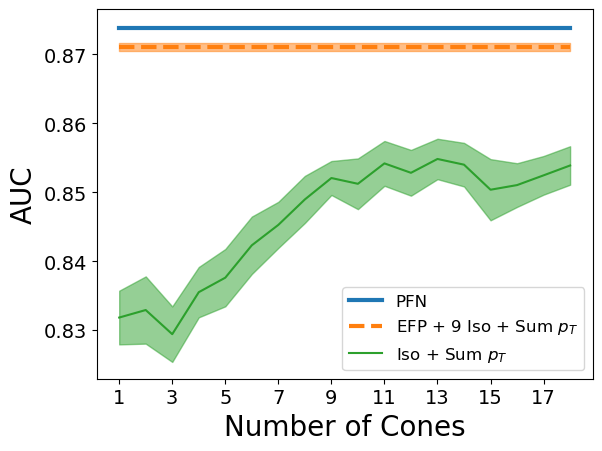

In [24]:
mask = np.isfinite(iso_avg)
fig, ax = plt.subplots()
ax.plot(np.arange(num_cones)+1,np.ones(num_cones)*auc_avg_pfn, label='PFN',linewidth=3)
ax.fill_between(np.arange(num_cones)+1,auc_avg_pfn-auc_se_pfn,auc_avg_pfn+auc_se_pfn,
        alpha=0.75)
ax.plot(np.arange(num_cones)+1,np.ones(num_cones)*auc_avg_efp, label='EFP + 9 Iso + Sum $p_T$',
        linewidth=3,linestyle='dashed')
current_color = ax.get_lines()[-1].get_color()
ax.fill_between(np.arange(num_cones)+1,auc_avg_efp-auc_se_efp,auc_avg_efp+auc_se_efp,
        alpha=0.5,color=current_color)#,hatch='++',facecolor='none')
ax.plot((np.arange(num_cones)+1)[mask],iso_avg[mask],label='Iso + Sum $p_T$')
current_color = ax.get_lines()[-1].get_color()
ax.fill_between((np.arange(num_cones)+1)[mask],(iso_avg-iso_std)[mask],
        (iso_avg+iso_std)[mask],alpha=0.5,color=current_color)
ax.set_xlabel('Number of Cones',fontsize=label_fontsize)
ax.set_ylabel('AUC',fontsize=label_fontsize)
ax.legend(fontsize=legend_fontsize)
ax.set_xticks(np.arange(1,num_cones+1,2))
ax.tick_params(labelsize=tick_fontsize)
fig.savefig(f'{figure_dir}/iso_scan.pdf',bbox_inches='tight')
plt.show()

In [65]:
num_points = 1000
common_fprs = np.linspace(0,1,num_points)
pfn_fit_interps = np.empty((num_pfn_bootstraps,num_fit_bootstraps,num_points))
efp_fit_interps = np.empty((num_efp_bootstraps,num_fit_bootstraps,num_points))
quad_efp_fit_interps = np.empty((num_efp_bootstraps,num_fit_bootstraps,num_points))
safe_efp_fit_interps = np.empty((num_efp_bootstraps,num_fit_bootstraps,num_points))
unsafe_efp_fit_interps = np.empty((num_efp_bootstraps,num_fit_bootstraps,num_points))
iso_1_fit_interps = np.empty((num_iso_bootstraps,num_fit_bootstraps,num_points))
iso_9_fit_interps = np.empty((num_iso_bootstraps,num_fit_bootstraps,num_points))
iso_fit_interps = np.empty((num_folds,num_cones,num_fit_bootstraps,num_points))
for i in range(num_pfn_bootstraps):
    for j in range(num_fit_bootstraps):
        pfn_fit_interps[i][j] = np.interp(common_fprs, np.flip(pfn_fprs[i][j]), np.flip(pfn_tprs[i][j]))
        efp_fit_interps[i][j] = np.interp(common_fprs, np.flip(efp_fprs[i][j]), np.flip(efp_tprs[i][j]))
        quad_efp_fit_interps[i][j] = np.interp(common_fprs, np.flip(quad_efp_fprs[i][j]),
                                               np.flip(quad_efp_tprs[i][j]))
        safe_efp_fit_interps[i][j] = np.interp(common_fprs, np.flip(safe_efp_fprs[i][j]), 
                                               np.flip(safe_efp_tprs[i][j]))
        unsafe_efp_fit_interps[i][j] = np.interp(common_fprs, np.flip(unsafe_efp_fprs[i][j]), 
                                                 np.flip(unsafe_efp_tprs[i][j]))
        iso_1_fit_interps[i][j] = np.interp(common_fprs, np.flip(iso_1_fprs[i][j]), 
                                            np.flip(iso_1_tprs[i][j]))
        iso_9_fit_interps[i][j] = np.interp(common_fprs, np.flip(iso_9_fprs[i][j]), 
                                            np.flip(iso_9_tprs[i][j]))
for i in range(num_folds):
    for j in range(num_cones):
        for k in range(num_fit_bootstraps):
            iso_fit_interps[i][j][k] = np.interp(common_fprs, np.flip(iso_fprs[i][j][k]),
                                                 np.flip(iso_tprs[i][j][k]))

In [67]:
pfn_test_interps = np.mean(pfn_fit_interps,axis=1)
efp_test_interps = np.mean(efp_fit_interps,axis=1)
quad_efp_test_interps = np.mean(quad_efp_fit_interps,axis=1)
safe_efp_test_interps = np.mean(safe_efp_fit_interps,axis=1)
unsafe_efp_test_interps = np.mean(unsafe_efp_fit_interps,axis=1)
iso_1_test_interps = np.mean(iso_1_fit_interps,axis=1)
iso_9_test_interps = np.mean(iso_9_fit_interps,axis=1)
iso_test_interps = np.mean(iso_fit_interps,axis=2)

In [77]:
fixed_fpr = 0.5

pfn_tpr_at_fixed_fprs = []
efp_tpr_at_fixed_fprs = []
for i in range(num_pfn_bootstraps):

    idx = np.abs(common_fprs-fixed_fpr).argmin()
    pfn_tpr_at_fixed_fprs.append(pfn_test_interps[i][idx])

    idx = np.abs(common_fprs-fixed_fpr).argmin()
    efp_tpr_at_fixed_fprs.append(efp_test_interps[i][idx])

pfn_tpr_at_fixed_fpr_avg = np.mean(pfn_tpr_at_fixed_fprs)
efp_tpr_at_fixed_fpr_avg = np.mean(efp_tpr_at_fixed_fprs)
pfn_tpr_at_fixed_fpr_se = np.std(pfn_tpr_at_fixed_fprs, ddof=1) / np.sqrt(num_pfn_bootstraps)
efp_tpr_at_fixed_fpr_se = np.std(efp_tpr_at_fixed_fprs, ddof=1) / np.sqrt(num_efp_bootstraps)

iso_tpr_at_fixed_fprs = []
for i in range(num_folds):
    cone_tprs = []
    for j in range(num_cones):
        idx = np.abs(common_fprs-fixed_fpr).argmin()
        cone_tprs.append(iso_test_interps[i][j][idx])
    iso_tpr_at_fixed_fprs.append(cone_tprs)

iso_tpr_at_fixed_fpr_avg = np.mean(iso_tpr_at_fixed_fprs,axis=0)
iso_tpr_at_fixed_fpr_std = np.std(iso_tpr_at_fixed_fprs,axis=0)

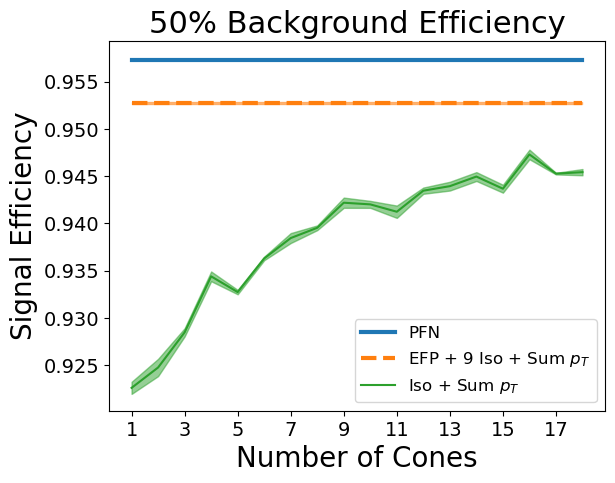

In [78]:
fig, ax = plt.subplots()
ax.plot(np.arange(num_cones)+1,np.ones(num_cones)*pfn_tpr_at_fixed_fpr_avg, 
        label='PFN',linewidth=3)
ax.fill_between(np.arange(num_cones)+1,pfn_tpr_at_fixed_fpr_avg-pfn_tpr_at_fixed_fpr_se,
        pfn_tpr_at_fixed_fpr_avg+pfn_tpr_at_fixed_fpr_se,alpha=0.75)
ax.plot(np.arange(num_cones)+1,np.ones(num_cones)*efp_tpr_at_fixed_fpr_avg, 
        label='EFP + 9 Iso + Sum $p_T$',linewidth=3,linestyle='dashed')
current_color = ax.get_lines()[-1].get_color()
ax.fill_between(np.arange(num_cones)+1,efp_tpr_at_fixed_fpr_avg-efp_tpr_at_fixed_fpr_se,
        efp_tpr_at_fixed_fpr_avg+efp_tpr_at_fixed_fpr_se,alpha=0.5,
        color=current_color)
ax.plot((np.arange(num_cones)+1),iso_tpr_at_fixed_fpr_avg,label='Iso + Sum $p_T$')
current_color = ax.get_lines()[-1].get_color()
ax.fill_between((np.arange(num_cones)+1),(iso_tpr_at_fixed_fpr_avg-iso_tpr_at_fixed_fpr_std),
                (iso_tpr_at_fixed_fpr_avg+iso_tpr_at_fixed_fpr_std),
                alpha=0.5,color=current_color)
ax.set_title(f'{fixed_fpr*100:0.0f}% Background Efficiency',fontsize=title_fontsize)
ax.set_xlabel('Number of Cones',fontsize=label_fontsize)
ax.set_ylabel('Signal Efficiency',fontsize=label_fontsize)
ax.legend(fontsize=legend_fontsize)
ax.set_xticks(np.arange(1,num_cones+1,2))
ax.tick_params(labelsize=tick_fontsize)
fig.savefig(f'{figure_dir}/sig_eff_at_bg_eff.pdf',bbox_inches='tight')
plt.show()

In [79]:
fixed_fpr = 0.5

pfn_tpr_at_fixed_fprs = []
efp_ado_tpr_at_fixed_fprs = []
efp_quad_tpr_at_fixed_fprs = []
efp_unsafe_tpr_at_fixed_fprs = []
efp_safe_tpr_at_fixed_fprs = []
iso_1_tpr_at_fixed_fprs = []
iso_9_tpr_at_fixed_fprs = []
for i in range(num_pfn_bootstraps):

    idx = np.abs(common_fprs-fixed_fpr).argmin()

    pfn_tpr_at_fixed_fprs.append(pfn_test_interps[i][idx])
    efp_ado_tpr_at_fixed_fprs.append(efp_test_interps[i][idx])
    efp_quad_tpr_at_fixed_fprs.append(quad_efp_test_interps[i][idx])
    efp_safe_tpr_at_fixed_fprs.append(safe_efp_test_interps[i][idx])
    efp_unsafe_tpr_at_fixed_fprs.append(unsafe_efp_test_interps[i][idx])
    iso_1_tpr_at_fixed_fprs.append(iso_1_test_interps[i][idx])
    iso_9_tpr_at_fixed_fprs.append(iso_9_test_interps[i][idx])

pfn_tpr_at_fixed_fpr_avg = np.mean(pfn_tpr_at_fixed_fprs)
efp_ado_tpr_at_fixed_fpr_avg = np.mean(efp_ado_tpr_at_fixed_fprs)
efp_quad_tpr_at_fixed_fpr_avg = np.mean(efp_quad_tpr_at_fixed_fprs)
efp_safe_tpr_at_fixed_fpr_avg = np.mean(efp_safe_tpr_at_fixed_fprs)
efp_unsafe_tpr_at_fixed_fpr_avg = np.mean(efp_unsafe_tpr_at_fixed_fprs)
iso_1_tpr_at_fixed_fpr_avg = np.mean(iso_1_tpr_at_fixed_fprs)
iso_9_tpr_at_fixed_fpr_avg = np.mean(iso_9_tpr_at_fixed_fprs)
pfn_tpr_at_fixed_fpr_se = np.std(pfn_tpr_at_fixed_fprs, ddof=1) / np.sqrt(num_pfn_bootstraps)
efp_ado_tpr_at_fixed_fpr_se = np.std(efp_ado_tpr_at_fixed_fprs, ddof=1) / np.sqrt(num_efp_bootstraps)
efp_quad_tpr_at_fixed_fpr_se = np.std(efp_quad_tpr_at_fixed_fprs, ddof=1) / np.sqrt(num_efp_bootstraps)
efp_safe_tpr_at_fixed_fpr_se = np.std(efp_safe_tpr_at_fixed_fprs, ddof=1) / np.sqrt(num_efp_bootstraps)
efp_unsafe_tpr_at_fixed_fpr_se = np.std(efp_unsafe_tpr_at_fixed_fprs, ddof=1) / np.sqrt(num_efp_bootstraps)
iso_1_tpr_at_fixed_fpr_se = np.std(iso_1_tpr_at_fixed_fprs, ddof=1) / np.sqrt(num_efp_bootstraps)
iso_9_tpr_at_fixed_fpr_se = np.std(iso_9_tpr_at_fixed_fprs, ddof=1) / np.sqrt(num_efp_bootstraps)

print(f'PFN TPR at {fixed_fpr*100:0.0f}% FPR: {pfn_tpr_at_fixed_fpr_avg:0.3f} +/- {pfn_tpr_at_fixed_fpr_se:0.4f}')
print(f'EFP ADO TPR at {fixed_fpr*100:0.0f}% FPR: {efp_ado_tpr_at_fixed_fpr_avg:0.3f} +/- {efp_ado_tpr_at_fixed_fpr_se:0.4f}')
print(f'EFP Quad TPR at {fixed_fpr*100:0.0f}% FPR: {efp_quad_tpr_at_fixed_fpr_avg:0.3f} +/- {efp_quad_tpr_at_fixed_fpr_se:0.4f}')
print(f'EFP Safe TPR at {fixed_fpr*100:0.0f}% FPR: {efp_safe_tpr_at_fixed_fpr_avg:0.3f} +/- {efp_safe_tpr_at_fixed_fpr_se:0.4f}')
print(f'EFP Unsafe TPR at {fixed_fpr*100:0.0f}% FPR: {efp_unsafe_tpr_at_fixed_fpr_avg:0.3f} +/- {efp_unsafe_tpr_at_fixed_fpr_se:0.4f}')
print(f'Iso 1 TPR at {fixed_fpr*100:0.0f}% FPR: {iso_1_tpr_at_fixed_fpr_avg:0.3f} +/- {iso_1_tpr_at_fixed_fpr_se:0.4f}')
print(f'Iso 9 TPR at {fixed_fpr*100:0.0f}% FPR: {iso_9_tpr_at_fixed_fpr_avg:0.3f} +/- {iso_9_tpr_at_fixed_fpr_se:0.4f}')

PFN TPR at 50% FPR: 0.957 +/- 0.0002
EFP ADO TPR at 50% FPR: 0.953 +/- 0.0001
EFP Quad TPR at 50% FPR: 0.956 +/- 0.0001
EFP Safe TPR at 50% FPR: 0.949 +/- 0.0001
EFP Unsafe TPR at 50% FPR: 0.954 +/- 0.0001
Iso 1 TPR at 50% FPR: 0.922 +/- 0.0002
Iso 9 TPR at 50% FPR: 0.939 +/- 0.0001


/tmp/ipykernel_31267/1318103852.py:3: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(np.mean(pfn_test_interps,axis=0), 1/common_fprs,
/tmp/ipykernel_31267/1318103852.py:5: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(np.mean(safe_efp_test_interps,axis=0), 1/common_fprs,
/tmp/ipykernel_31267/1318103852.py:7: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(np.mean(efp_test_interps,axis=0), 1/common_fprs,
/tmp/ipykernel_31267/1318103852.py:9: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(np.mean(unsafe_efp_test_interps,axis=0), 1/common_fprs,
/tmp/ipykernel_31267/1318103852.py:11: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(np.mean(quad_efp_test_interps,axis=0), 1/common_fprs,
/tmp/ipykernel_31267/1318103852.py:13: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(np.mean(iso_9_test_interps,axis=0), 1/common_fprs,
/tmp/ipykernel_31267/1318103852.py:15: RuntimeWar

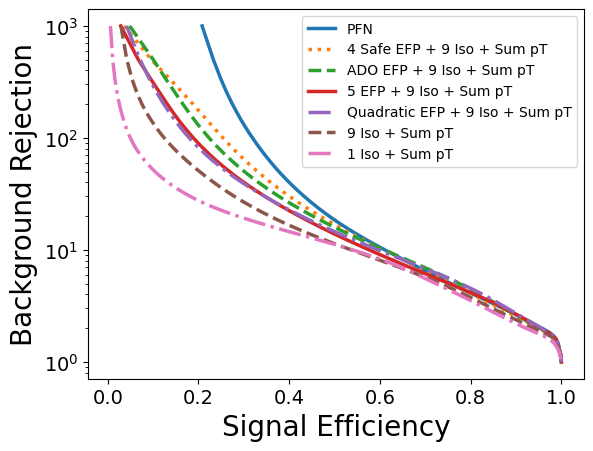

In [81]:
line_width = 2.5
fig, ax = plt.subplots()
ax.plot(np.mean(pfn_test_interps,axis=0), 1/common_fprs, 
        linestyle='-', linewidth=line_width, label='PFN')
ax.plot(np.mean(safe_efp_test_interps,axis=0), 1/common_fprs, 
        linestyle=':', linewidth=line_width, label='4 Safe EFP + 9 Iso + Sum pT')
ax.plot(np.mean(efp_test_interps,axis=0), 1/common_fprs, 
        linestyle='--', linewidth=line_width, label='ADO EFP + 9 Iso + Sum pT')
ax.plot(np.mean(unsafe_efp_test_interps,axis=0), 1/common_fprs, 
        linestyle='-', linewidth=line_width, label='5 EFP + 9 Iso + Sum pT')
ax.plot(np.mean(quad_efp_test_interps,axis=0), 1/common_fprs, 
        linestyle='-.', linewidth=line_width, label='Quadratic EFP + 9 Iso + Sum pT')
ax.plot(np.mean(iso_9_test_interps,axis=0), 1/common_fprs, 
        linestyle='--', linewidth=line_width, label='9 Iso + Sum pT')
ax.plot(np.mean(iso_1_test_interps,axis=0), 1/common_fprs, 
        linestyle='-.', linewidth=line_width, label='1 Iso + Sum pT')
ax.set_yscale('log')
ax.set_xlabel('Signal Efficiency',fontsize=label_fontsize)
ax.set_ylabel('Background Rejection',fontsize=label_fontsize)
ax.legend(fontsize=legend_fontsize-2)
ax.tick_params(labelsize=tick_fontsize)
fig.savefig(f'{figure_dir}/sig_eff_bg_rej.pdf',bbox_inches='tight')
plt.show()